## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [3]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [4]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros
0   2020-01-01      1.289946
1   2020-01-02      0.735046
2   2020-01-03      0.591834
3   2020-01-04      1.367154
4   2020-01-05      1.505321
..         ...           ...
913 2022-07-02      0.778572
914 2022-07-03      0.819483
915 2022-07-04      0.843804
916 2022-07-05      0.850985
917 2022-07-06      0.840437

[918 rows x 2 columns]

---

## Desarrollo del modelo

In [4]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [5]:
df_stats=df

In [6]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

In [7]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [8]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [9]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [10]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [11]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(637, 5, 1) (637, 1)
(271, 5, 1) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 25ms/step - loss: 0.9422 - mae: 0.7249 - val_loss: 1.4640 - val_mae: 0.7864
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9370 - mae: 0.7211 - val_loss: 1.4503 - val_mae: 0.7824
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9339 - mae: 0.7201 - val_loss: 1.4373 - val_mae: 0.7797
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9316 - mae: 0.7178 - val_loss: 1.4293 - val_mae: 0.7767
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9299 - mae: 0.7169 - val_loss: 1.4237 - val_mae: 0.7758
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9285 - mae: 0.7162 - val_loss: 1.4181 - val_mae: 0.7743
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9273 - mae: 0.7146 - val_loss: 1.4119 - val_mae: 0.7723
Epoch 8/100
32/32 [=====================

Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9016 - mae: 0.7047 - val_loss: 1.3309 - val_mae: 0.7493
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9014 - mae: 0.7049 - val_loss: 1.3302 - val_mae: 0.7492
Epoch 65/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9010 - mae: 0.7046 - val_loss: 1.3285 - val_mae: 0.7484
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9009 - mae: 0.7042 - val_loss: 1.3267 - val_mae: 0.7481
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9010 - mae: 0.7051 - val_loss: 1.3291 - val_mae: 0.7482
Epoch 68/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9004 - mae: 0.7046 - val_loss: 1.3260 - val_mae: 0.7481
Epoch 69/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9002 - mae: 0.7047 - val_loss: 1.3269 - val_mae: 0.7479
Epoch 70/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

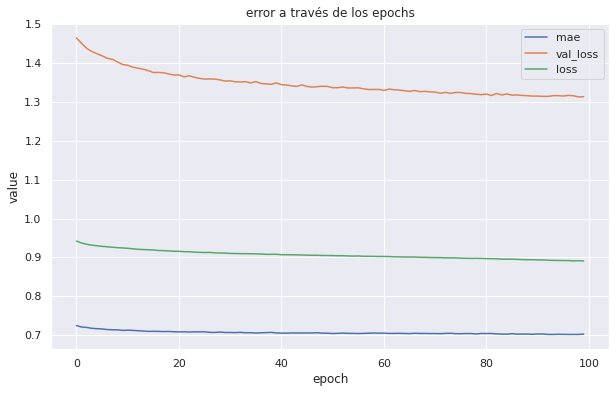

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.5190321622619123
MAE is : 0.8869450317829297
RMSE is : 1.2324902280594001
MAPE is : 42.95689880838377
Evaluation metric results:
MSE is : 1.2872352121241786
MAE is : 0.8743105851975073
RMSE is : 1.134563886312348
MAPE is : 42.99141537694715
(637, 5, 1) (637, 1)
(271, 5, 1) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 22ms/step - loss: 0.9331 - mae: 0.7148 - val_loss: 1.4098 - val_mae: 0.7730
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9294 - mae: 0.7134 - val_loss: 1.4058 - val_mae: 0.7712
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9269 - mae: 0.7135 - val_loss: 1.3985 - val_mae: 0.7699
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9250 - mae: 0.7123 - val_loss: 1.3949 - val_mae: 0.7678
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9236 - mae: 0.7122 - val_los

Epoch 60/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8998 - mae: 0.7062 - val_loss: 1.3236 - val_mae: 0.7475
Epoch 61/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9002 - mae: 0.7063 - val_loss: 1.3195 - val_mae: 0.7475
Epoch 62/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8997 - mae: 0.7053 - val_loss: 1.3254 - val_mae: 0.7463
Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8989 - mae: 0.7053 - val_loss: 1.3226 - val_mae: 0.7465
Epoch 64/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8987 - mae: 0.7056 - val_loss: 1.3214 - val_mae: 0.7464
Epoch 65/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8981 - mae: 0.7051 - val_loss: 1.3189 - val_mae: 0.7458
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8981 - mae: 0.7046 - val_loss: 1.3159 - val_mae: 0.7456
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

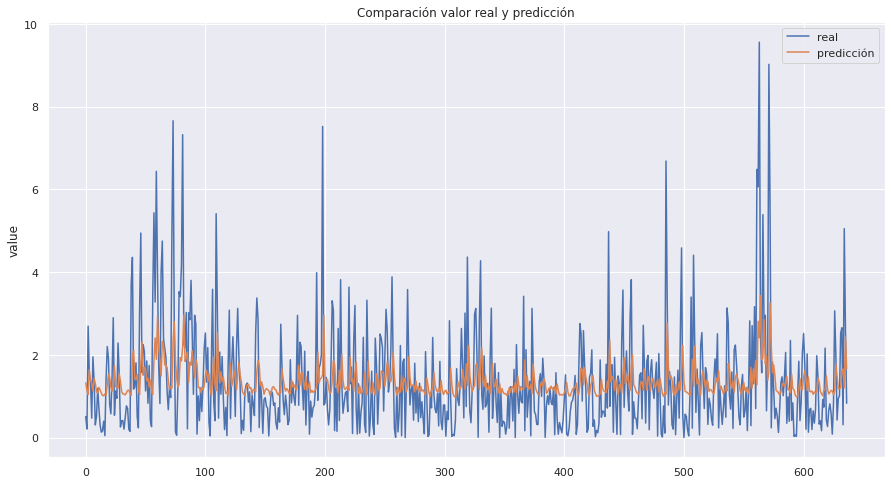

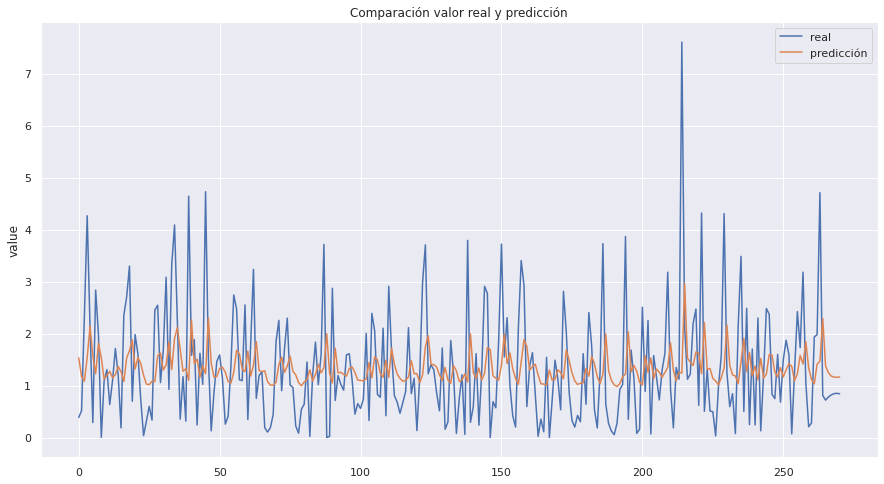

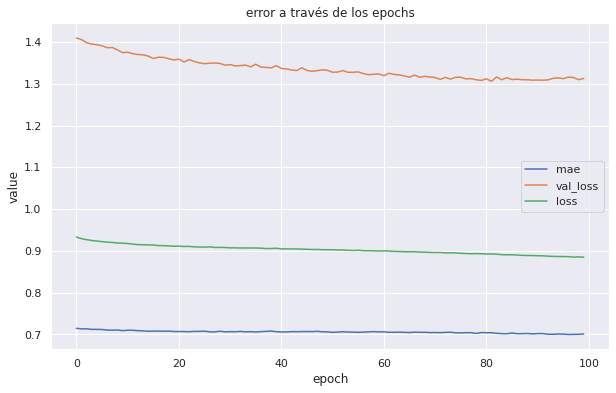

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.5111186493731992
MAE is : 0.8843743402564711
RMSE is : 1.2292756604493555
MAPE is : 42.844259253854595
Evaluation metric results:
MSE is : 1.2884361674887836
MAE is : 0.8764310521397782
RMSE is : 1.1350930215135602
MAPE is : 43.16002862829717
(637, 5, 1) (637, 1)
(271, 5, 1) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 25ms/step - loss: 0.9764 - mae: 0.7357 - val_loss: 1.5090 - val_mae: 0.7965
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9554 - mae: 0.7248 - val_loss: 1.4691 - val_mae: 0.7880
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9472 - mae: 0.7228 - val_loss: 1.4405 - val_mae: 0.7827
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9416 - mae: 0.7193 - val_loss: 1.4285 - val_mae: 0.7780
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9379 - mae: 0.7184 - val_l

Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8919 - mae: 0.7027 - val_loss: 1.3090 - val_mae: 0.7442
Epoch 61/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8923 - mae: 0.7030 - val_loss: 1.3023 - val_mae: 0.7437
Epoch 62/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8911 - mae: 0.7001 - val_loss: 1.3132 - val_mae: 0.7427
Epoch 63/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8893 - mae: 0.7004 - val_loss: 1.3074 - val_mae: 0.7427
Epoch 64/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8883 - mae: 0.7003 - val_loss: 1.3065 - val_mae: 0.7424
Epoch 65/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8873 - mae: 0.6993 - val_loss: 1.3032 - val_mae: 0.7407
Epoch 66/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8866 - mae: 0.6985 - val_loss: 1.2992 - val_mae: 0.7405
Epoch 67/100
32/32 [==============================] - 0s 6ms/step - loss: 0.

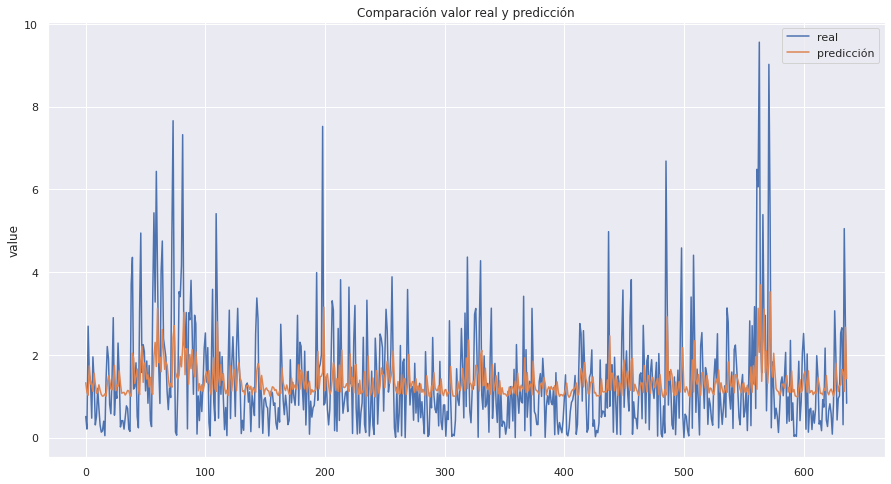

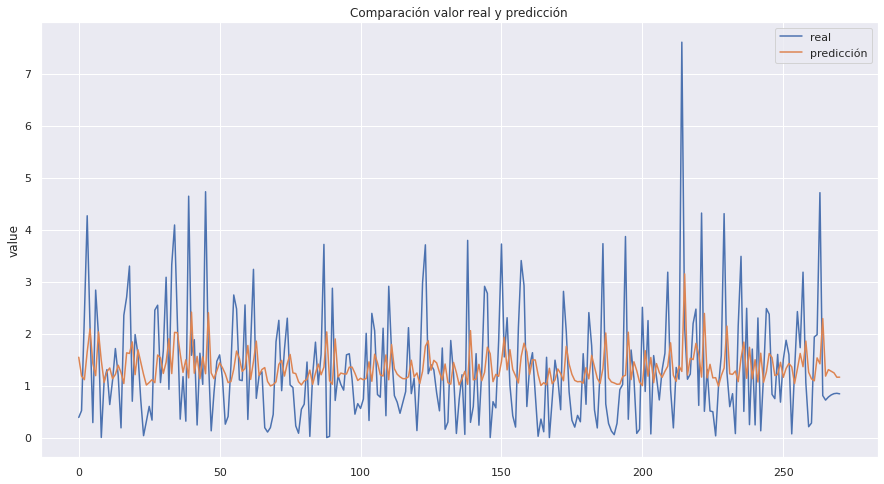

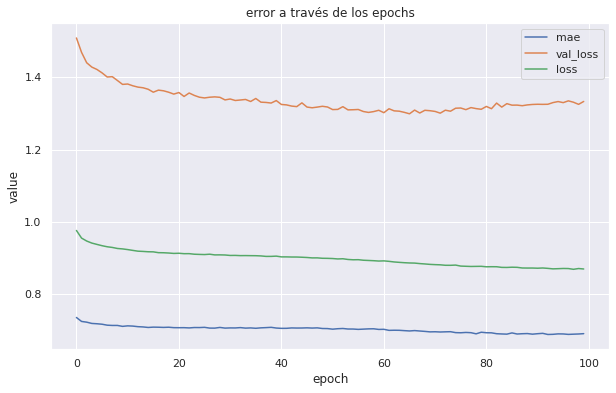

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.497199783966594
MAE is : 0.874890687806997
RMSE is : 1.2236011539576914
MAPE is : 42.311971018051814
Evaluation metric results:
MSE is : 1.3294298399671396
MAE is : 0.8891221947584821
RMSE is : 1.1530090372443487
MAPE is : 43.28002801253133
(637, 5, 1) (637, 1)
(271, 5, 1) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 26ms/step - loss: 0.9549 - mae: 0.7261 - val_loss: 1.4240 - val_mae: 0.7797
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9405 - mae: 0.7187 - val_loss: 1.4095 - val_mae: 0.7741
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9331 - mae: 0.7172 - val_loss: 1.3931 - val_mae: 0.7729
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9283 - mae: 0.7138 - val_loss: 1.3904 - val_mae: 0.7691
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9257 - mae: 0.7136 - val_los

Epoch 60/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8744 - mae: 0.6912 - val_loss: 1.3686 - val_mae: 0.7443
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8754 - mae: 0.6911 - val_loss: 1.3640 - val_mae: 0.7450
Epoch 62/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8754 - mae: 0.6899 - val_loss: 1.3751 - val_mae: 0.7438
Epoch 63/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8742 - mae: 0.6904 - val_loss: 1.3705 - val_mae: 0.7450
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8724 - mae: 0.6903 - val_loss: 1.3690 - val_mae: 0.7456
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8731 - mae: 0.6901 - val_loss: 1.3716 - val_mae: 0.7462
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8718 - mae: 0.6880 - val_loss: 1.3634 - val_mae: 0.7465
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0

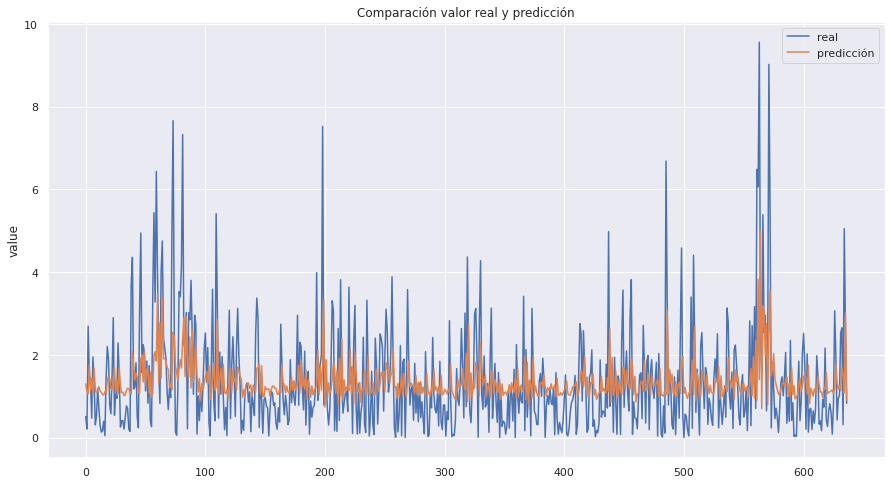

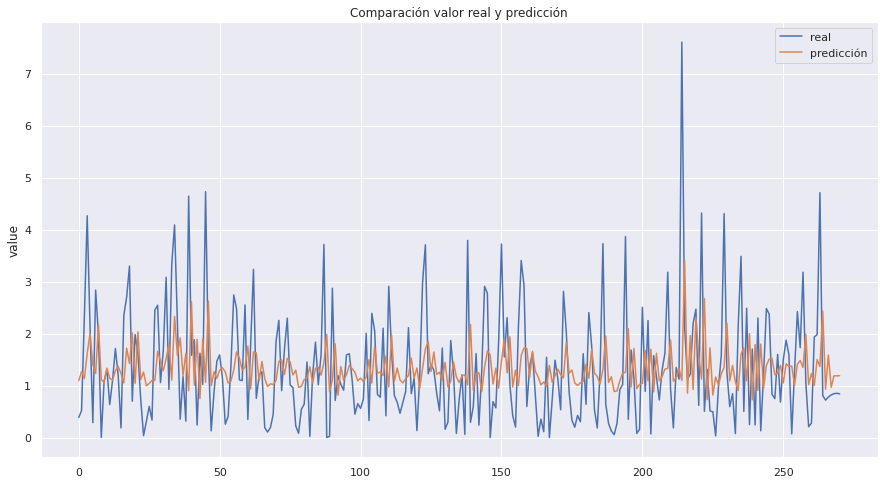

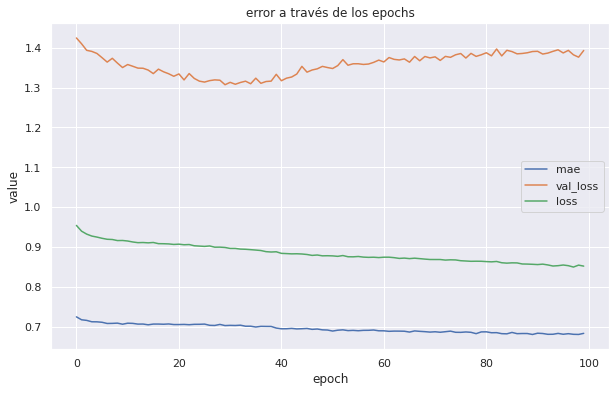

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4917002641645287
MAE is : 0.8728896845185712
RMSE is : 1.2213518183408616
MAPE is : 42.24091262467391
Evaluation metric results:
MSE is : 1.345515491845883
MAE is : 0.8856477498349471
RMSE is : 1.159963573499566
MAPE is : 42.871745301546426
(637, 5, 1) (637, 1)
(271, 5, 1) (271, 1)
Epoch 1/100
32/32 [==============================] - 3s 31ms/step - loss: 0.9480 - mae: 0.7218 - val_loss: 1.4136 - val_mae: 0.7744
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9326 - mae: 0.7152 - val_loss: 1.3928 - val_mae: 0.7700
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9256 - mae: 0.7140 - val_loss: 1.3800 - val_mae: 0.7688
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9214 - mae: 0.7110 - val_loss: 1.3791 - val_mae: 0.7654
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9194 - mae: 0.7117 - val

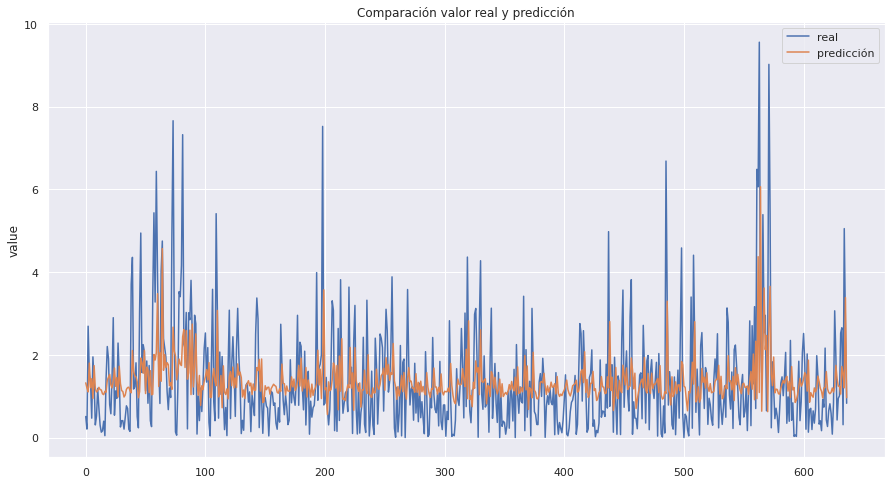

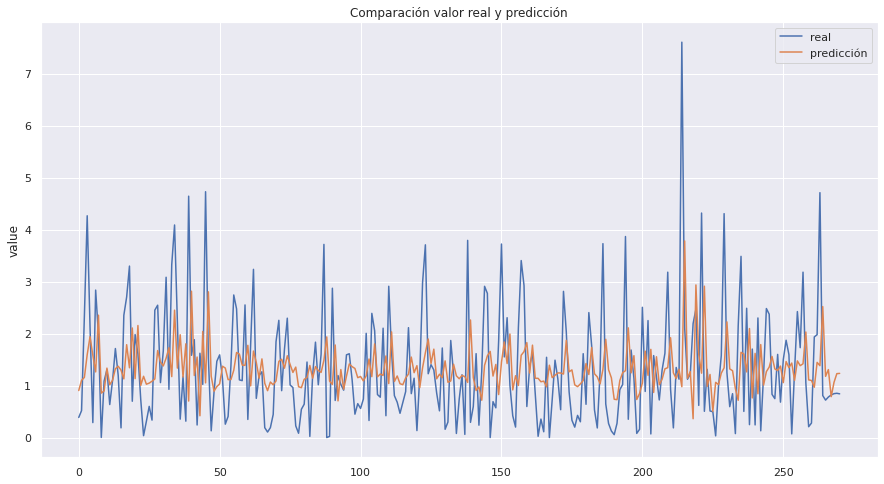

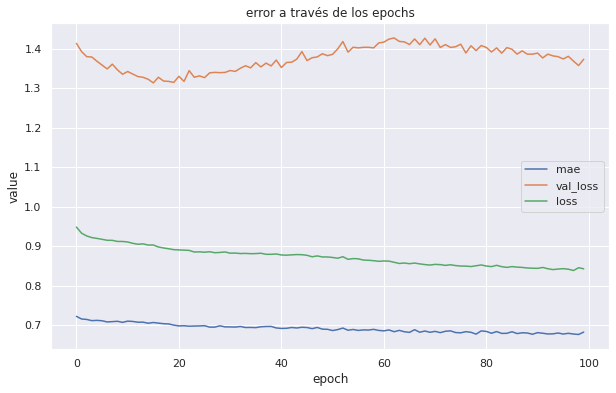

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.4683354525799168
MAE is : 0.8650910574132381
RMSE is : 1.21174892307768
MAPE is : 41.909162933793084
Evaluation metric results:
MSE is : 1.3672741880283672
MAE is : 0.8908393183185347
RMSE is : 1.169305002139462
MAPE is : 43.228794593452584
(637, 5, 1) (637, 1)
(271, 5, 1) (271, 1)
Epoch 1/100
32/32 [==============================] - 4s 43ms/step - loss: 0.9474 - mae: 0.7216 - val_loss: 1.4146 - val_mae: 0.7729
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9285 - mae: 0.7134 - val_loss: 1.3825 - val_mae: 0.7670
Epoch 3/100
32/32 [==============================] - 1s 24ms/step - loss: 0.9216 - mae: 0.7122 - val_loss: 1.3729 - val_mae: 0.7656
Epoch 4/100
32/32 [==============================] - 1s 25ms/step - loss: 0.9165 - mae: 0.7097 - val_loss: 1.3682 - val_mae: 0.7611
Epoch 5/100
32/32 [==============================] - 1s 25ms/step - loss: 0.9133 - mae: 0.7104 - val

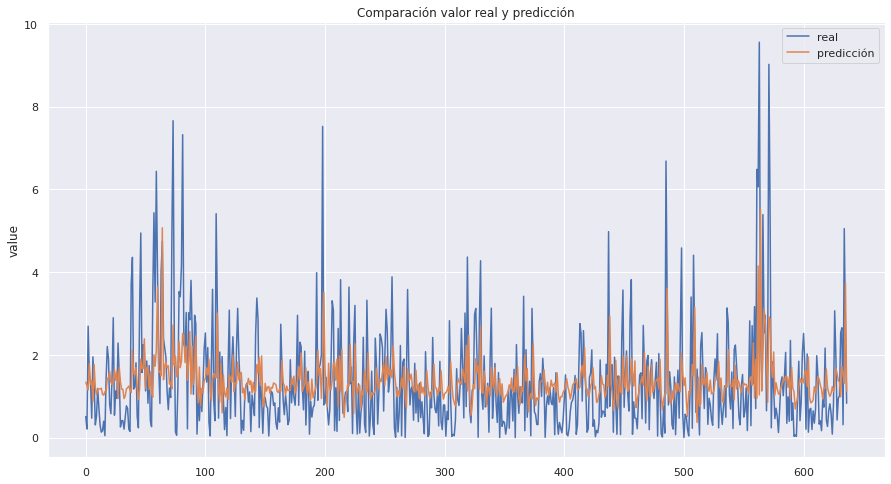

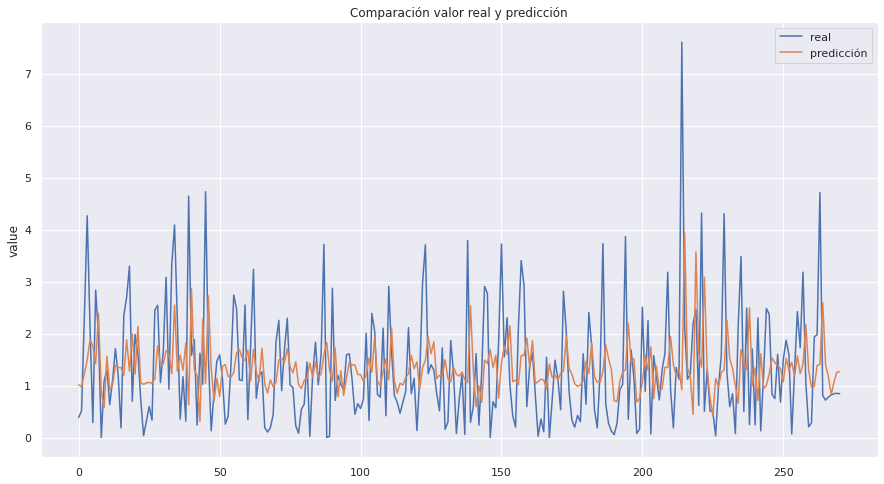

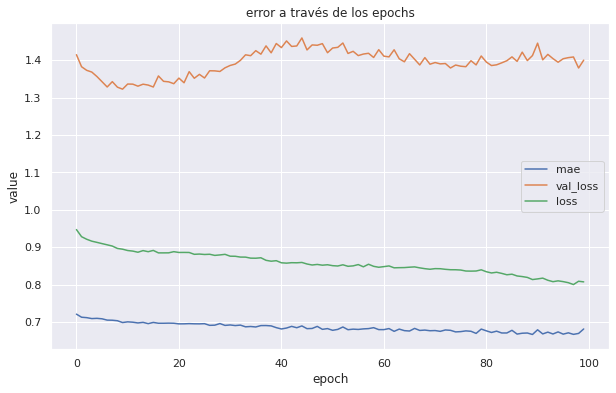

9/9 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.4205555095456754
MAE is : 0.861005552297226
RMSE is : 1.1918705926172
MAPE is : 41.801893693806406
Evaluation metric results:
MSE is : 1.3891816536843002
MAE is : 0.8922977910034874
RMSE is : 1.1786355050159911
MAPE is : 43.6339044952021
(634, 8, 1) (634, 1)
(268, 8, 1) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 0.9693 - mae: 0.7342 - val_loss: 1.5405 - val_mae: 0.8024
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.9463 - mae: 0.7232 - val_loss: 1.4978 - val_mae: 0.7918
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9345 - mae: 0.7177 - val_loss: 1.4658 - val_mae: 0.7865
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9266 - mae: 0.7139 - val_loss: 1.4387 - val_mae: 0.7806
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.9212 - mae: 0.7118 - val_loss: 

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8795 - mae: 0.6964 - val_loss: 1.3047 - val_mae: 0.7678
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8788 - mae: 0.6950 - val_loss: 1.3068 - val_mae: 0.7664
Epoch 62/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8784 - mae: 0.6957 - val_loss: 1.3046 - val_mae: 0.7675
Epoch 63/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8780 - mae: 0.6962 - val_loss: 1.3037 - val_mae: 0.7677
Epoch 64/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8769 - mae: 0.6958 - val_loss: 1.3046 - val_mae: 0.7672
Epoch 65/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8767 - mae: 0.6950 - val_loss: 1.3045 - val_mae: 0.7664
Epoch 66/100
32/32 [==============================] - 0s 7ms/step - loss: 0.8764 - mae: 0.6948 - val_loss: 1.3053 - val_mae: 0.7654
Epoch 67/100
32/32 [==============================] - 0s 7ms/step - loss: 0.

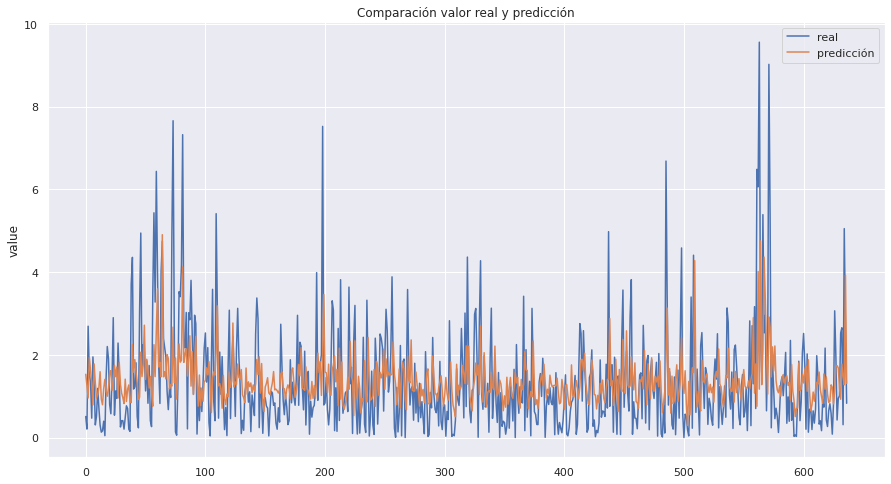

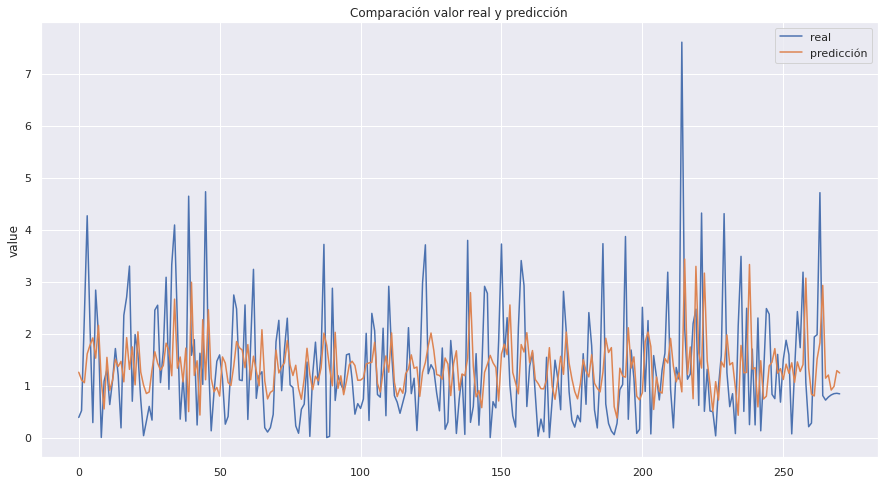

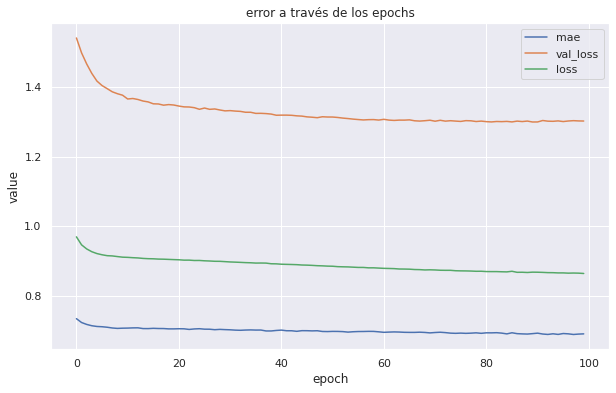

9/9 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.4818501578426293
MAE is : 0.8811862314662693
RMSE is : 1.2173126787488207
MAPE is : 42.780074089356226
Evaluation metric results:
MSE is : 1.2719938355848825
MAE is : 0.8657822670492524
RMSE is : 1.1278270415204996
MAPE is : 42.20253204609519
(634, 8, 1) (634, 1)
(268, 8, 1) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 26ms/step - loss: 0.9682 - mae: 0.7358 - val_loss: 1.5175 - val_mae: 0.7977
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9413 - mae: 0.7181 - val_loss: 1.4731 - val_mae: 0.7863
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9326 - mae: 0.7136 - val_loss: 1.4501 - val_mae: 0.7845
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9270 - mae: 0.7112 - val_loss: 1.4293 - val_mae: 0.7814
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9233 - mae: 0.7102 - val_l

Epoch 60/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8666 - mae: 0.6919 - val_loss: 1.3500 - val_mae: 0.7890
Epoch 61/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8637 - mae: 0.6876 - val_loss: 1.3490 - val_mae: 0.7848
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8653 - mae: 0.6910 - val_loss: 1.3491 - val_mae: 0.7867
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8647 - mae: 0.6905 - val_loss: 1.3462 - val_mae: 0.7842
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8636 - mae: 0.6901 - val_loss: 1.3476 - val_mae: 0.7856
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8633 - mae: 0.6883 - val_loss: 1.3452 - val_mae: 0.7840
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8625 - mae: 0.6887 - val_loss: 1.3479 - val_mae: 0.7858
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0.

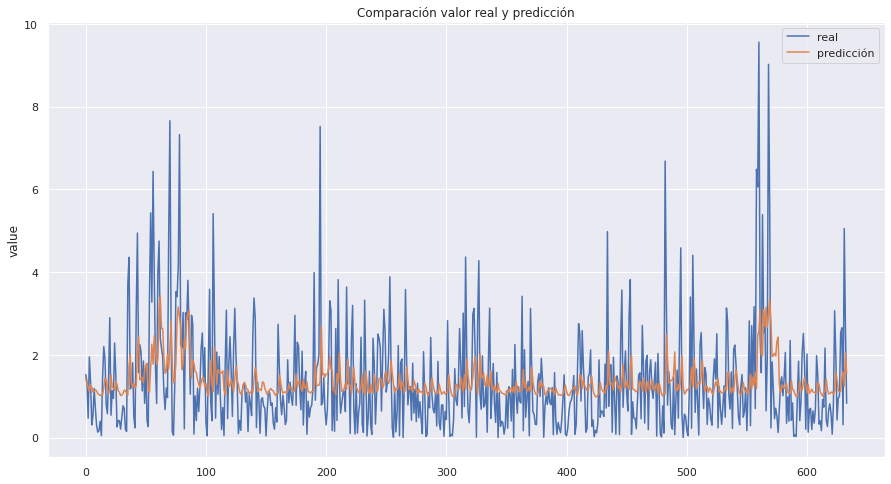

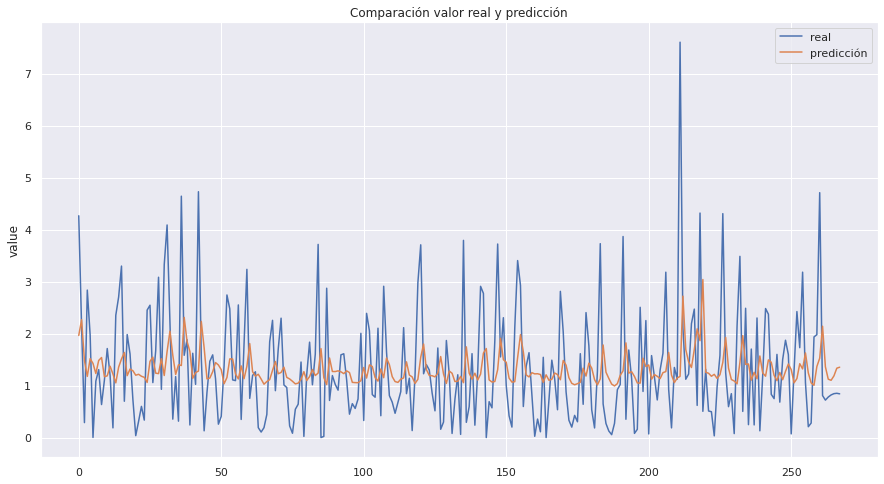

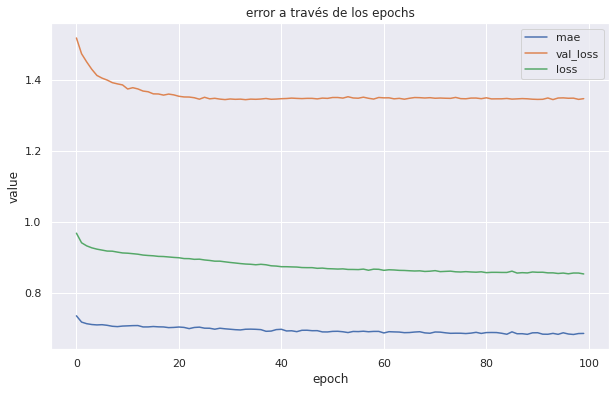

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.481748173053708
MAE is : 0.881881420640395
RMSE is : 1.2172707887128928
MAPE is : 42.96240766357992
Evaluation metric results:
MSE is : 1.2855045203582036
MAE is : 0.8720914557393797
RMSE is : 1.1338009174269545
MAPE is : 42.77154087184195
(634, 8, 1) (634, 1)
(268, 8, 1) (268, 1)
Epoch 1/100
32/32 [==============================] - 3s 28ms/step - loss: 0.9337 - mae: 0.7190 - val_loss: 1.4031 - val_mae: 0.7742
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9164 - mae: 0.7067 - val_loss: 1.3778 - val_mae: 0.7715
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9136 - mae: 0.7070 - val_loss: 1.3751 - val_mae: 0.7718
Epoch 4/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9095 - mae: 0.7053 - val_loss: 1.3635 - val_mae: 0.7720
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.9070 - mae: 0.7053 - val_loss

Epoch 60/100
32/32 [==============================] - 0s 10ms/step - loss: 0.8637 - mae: 0.6926 - val_loss: 1.3231 - val_mae: 0.7785
Epoch 61/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8599 - mae: 0.6871 - val_loss: 1.3244 - val_mae: 0.7769
Epoch 62/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8623 - mae: 0.6914 - val_loss: 1.3228 - val_mae: 0.7756
Epoch 63/100
32/32 [==============================] - 0s 9ms/step - loss: 0.8624 - mae: 0.6914 - val_loss: 1.3193 - val_mae: 0.7750
Epoch 64/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8605 - mae: 0.6903 - val_loss: 1.3206 - val_mae: 0.7762
Epoch 65/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8598 - mae: 0.6883 - val_loss: 1.3176 - val_mae: 0.7772
Epoch 66/100
32/32 [==============================] - 0s 8ms/step - loss: 0.8581 - mae: 0.6888 - val_loss: 1.3222 - val_mae: 0.7794
Epoch 67/100
32/32 [==============================] - 0s 8ms/step - loss: 0

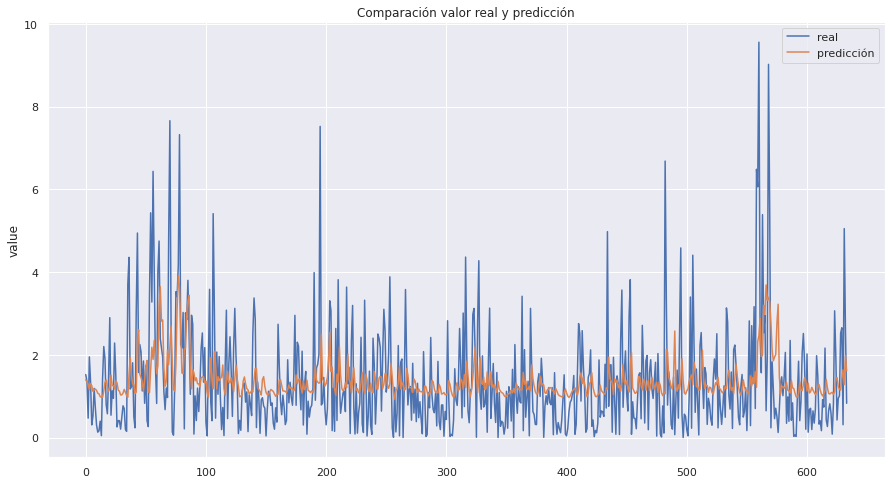

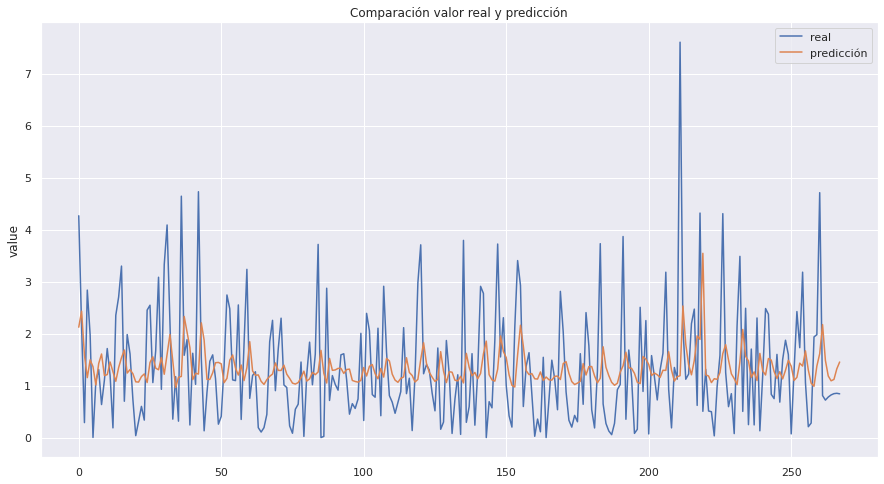

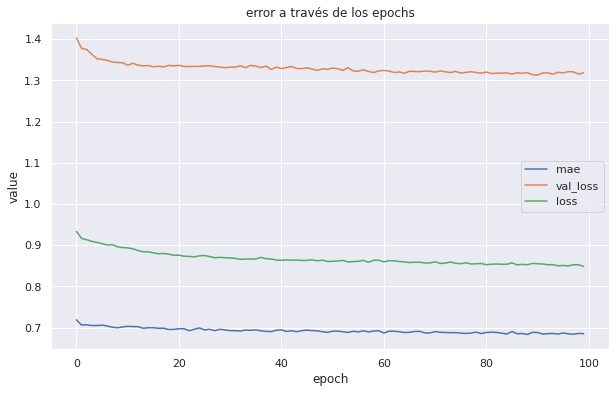

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.4654756214790132
MAE is : 0.8781080274960125
RMSE is : 1.2105683051686977
MAPE is : 42.725005588831195
Evaluation metric results:
MSE is : 1.285220529892549
MAE is : 0.8716200379547647
RMSE is : 1.133675672268109
MAPE is : 42.73642696923062
(634, 8, 1) (634, 1)
(268, 8, 1) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 32ms/step - loss: 0.9398 - mae: 0.7221 - val_loss: 1.3983 - val_mae: 0.7799
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9180 - mae: 0.7072 - val_loss: 1.3827 - val_mae: 0.7808
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9135 - mae: 0.7090 - val_loss: 1.3875 - val_mae: 0.7762
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9055 - mae: 0.7054 - val_loss: 1.3653 - val_mae: 0.7815
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9016 - mae: 0.7066 - val

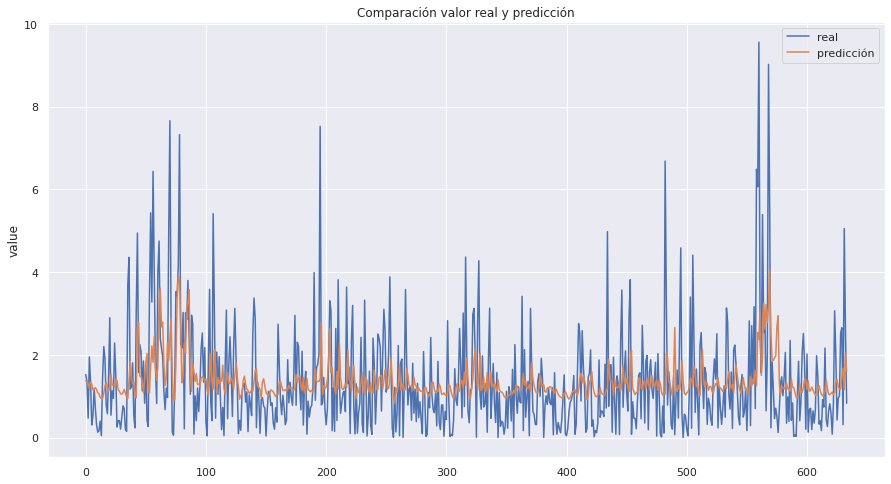

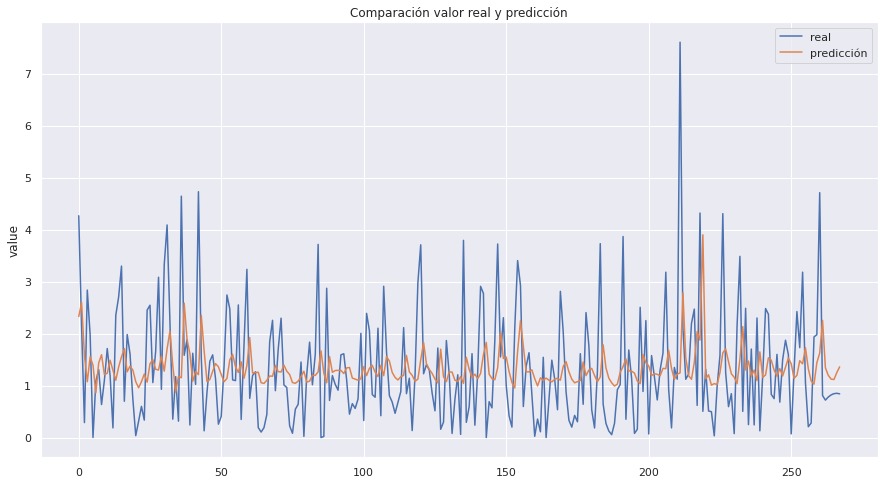

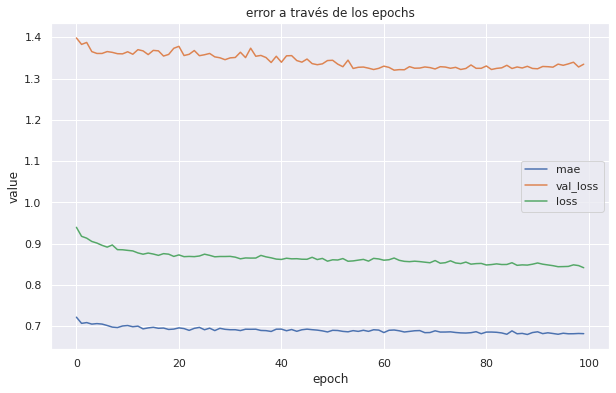

9/9 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.4591934275831018
MAE is : 0.8728812038392314
RMSE is : 1.2079707892093674
MAPE is : 42.466598742446934
Evaluation metric results:
MSE is : 1.2839173189571218
MAE is : 0.8723427684912409
RMSE is : 1.1331007541066778
MAPE is : 42.7996699940121
(634, 8, 1) (634, 1)
(268, 8, 1) (268, 1)
Epoch 1/100
32/32 [==============================] - 4s 41ms/step - loss: 0.9519 - mae: 0.7260 - val_loss: 1.4049 - val_mae: 0.7788
Epoch 2/100
32/32 [==============================] - 1s 20ms/step - loss: 0.9184 - mae: 0.7063 - val_loss: 1.3829 - val_mae: 0.7823
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9116 - mae: 0.7090 - val_loss: 1.3909 - val_mae: 0.7748
Epoch 4/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8979 - mae: 0.7027 - val_loss: 1.3711 - val_mae: 0.7977
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.8942 - mae: 0.7093 - va

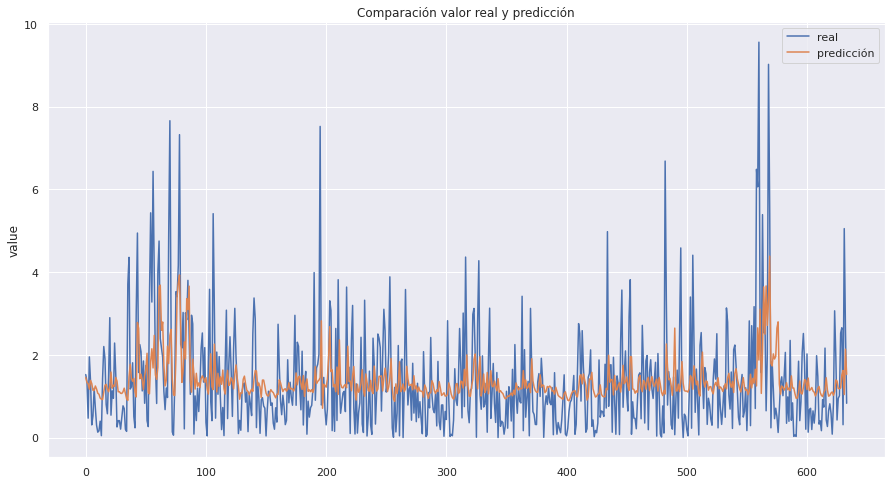

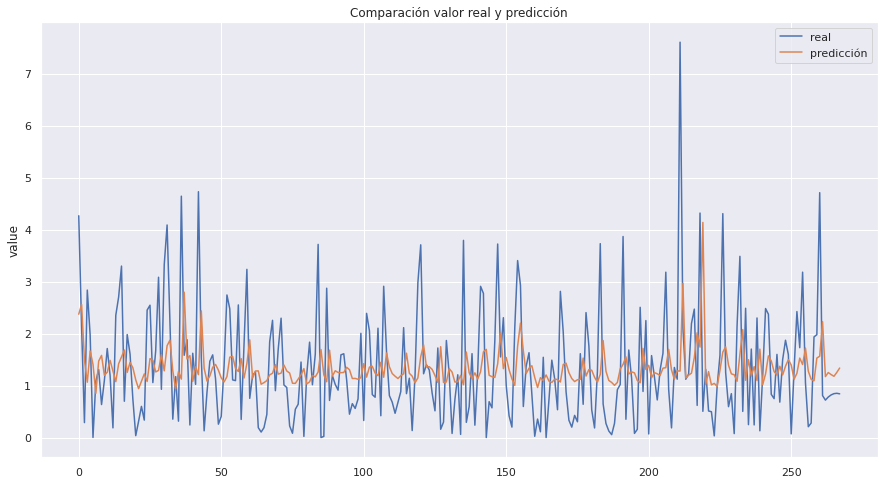

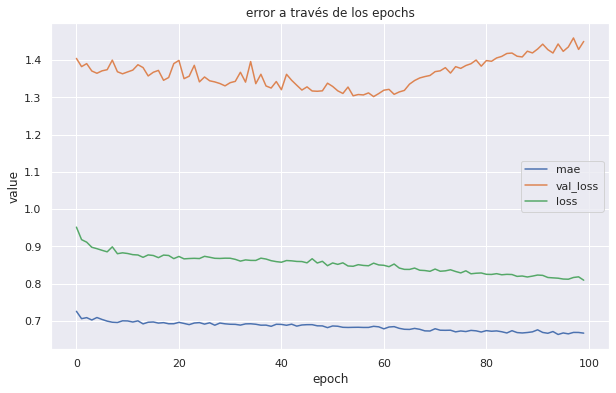

9/9 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.4487896641502669
MAE is : 0.8552541468893948
RMSE is : 1.2036567883538343
MAPE is : 41.64351370091548
Evaluation metric results:
MSE is : 1.334444291971645
MAE is : 0.891702201435384
RMSE is : 1.1551814974157286
MAPE is : 43.91709764288315
(634, 8, 1) (634, 1)
(268, 8, 1) (268, 1)
Epoch 1/100
32/32 [==============================] - 5s 63ms/step - loss: 0.9698 - mae: 0.7317 - val_loss: 1.4287 - val_mae: 0.7790
Epoch 2/100
32/32 [==============================] - 1s 43ms/step - loss: 0.9181 - mae: 0.7059 - val_loss: 1.3779 - val_mae: 0.7829
Epoch 3/100
32/32 [==============================] - 1s 43ms/step - loss: 0.9078 - mae: 0.7073 - val_loss: 1.3857 - val_mae: 0.7711
Epoch 4/100
32/32 [==============================] - 1s 42ms/step - loss: 0.8927 - mae: 0.7007 - val_loss: 1.3846 - val_mae: 0.8090
Epoch 5/100
32/32 [==============================] - 1s 41ms/step - loss: 0.8927 - mae: 0.7106 - val_

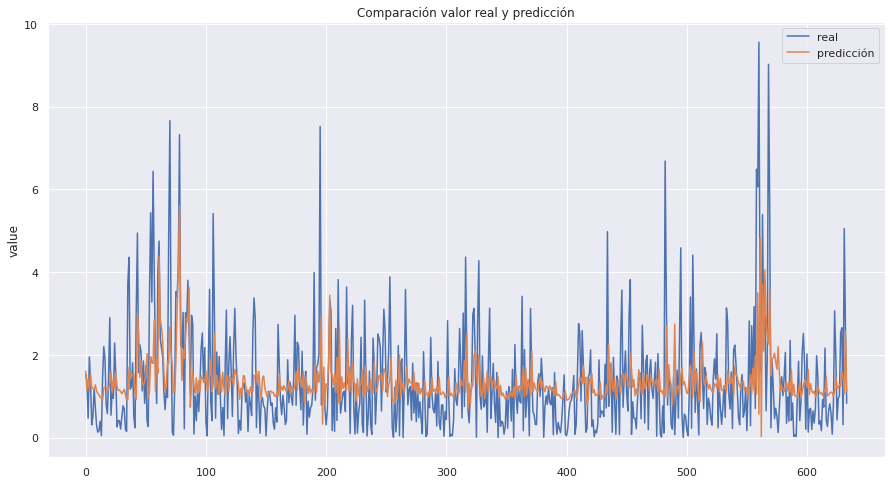

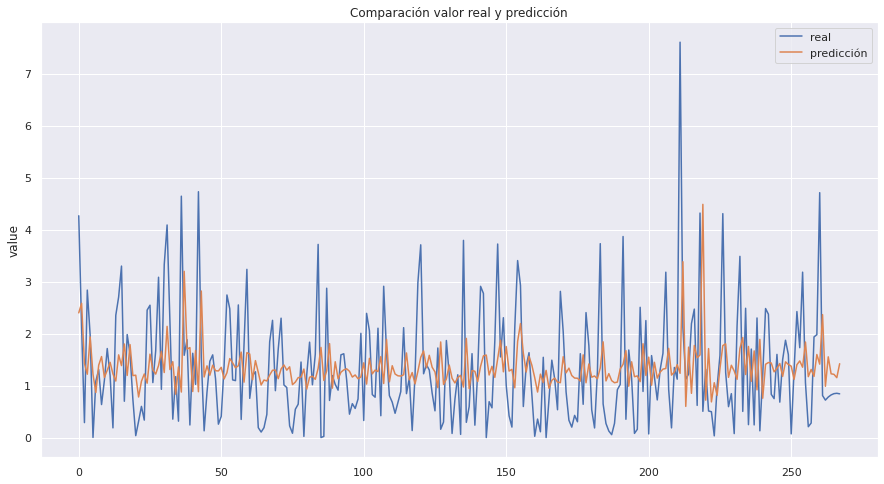

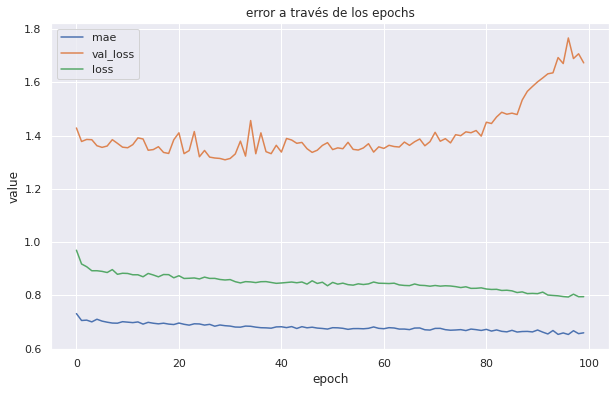

9/9 [==============================] - 0s 19ms/step
Evaluation metric results:
MSE is : 1.4992256019229244
MAE is : 0.8526101168628363
RMSE is : 1.2244286838860499
MAPE is : 40.96322242293461
Evaluation metric results:
MSE is : 1.3143813288193396
MAE is : 0.8811688966458252
RMSE is : 1.1464647089288618
MAPE is : 43.081813904159176
(632, 10, 1) (632, 1)
(266, 10, 1) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 38ms/step - loss: 0.9435 - mae: 0.7261 - val_loss: 1.4520 - val_mae: 0.7829
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9322 - mae: 0.7211 - val_loss: 1.4288 - val_mae: 0.7794
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9255 - mae: 0.7175 - val_loss: 1.4091 - val_mae: 0.7742
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9207 - mae: 0.7138 - val_loss: 1.3983 - val_mae: 0.7711
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.9169 - mae: 0.7111 

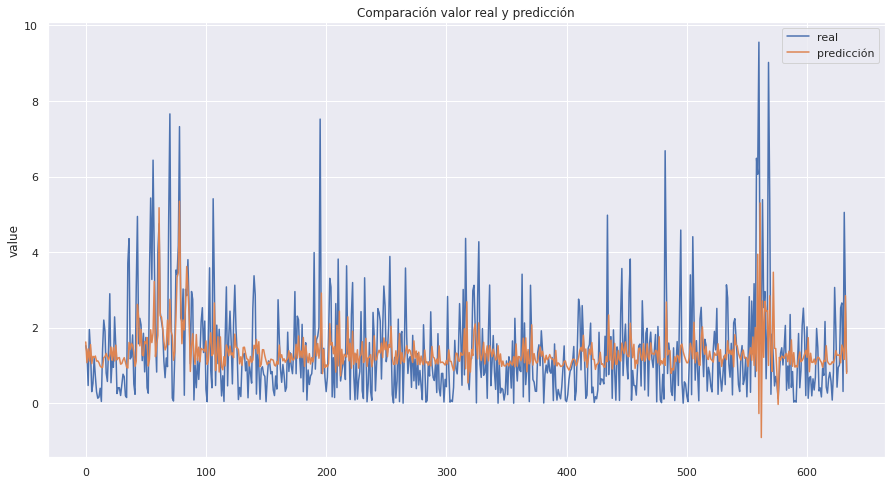

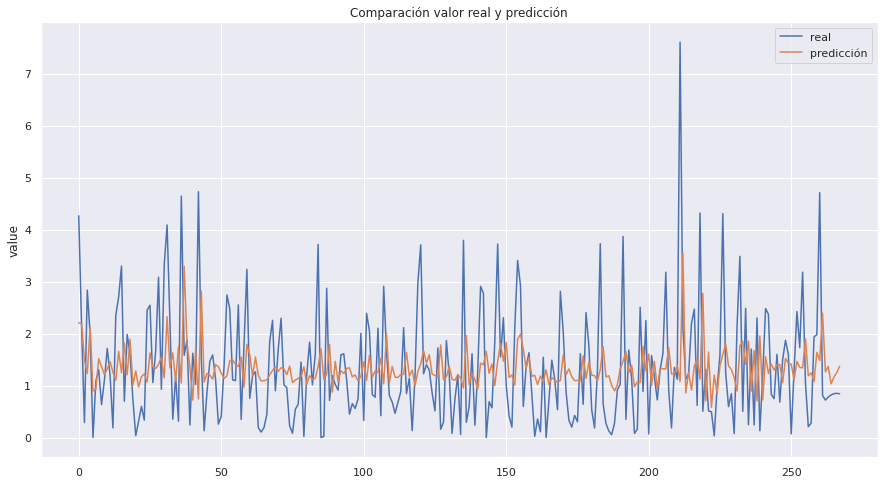

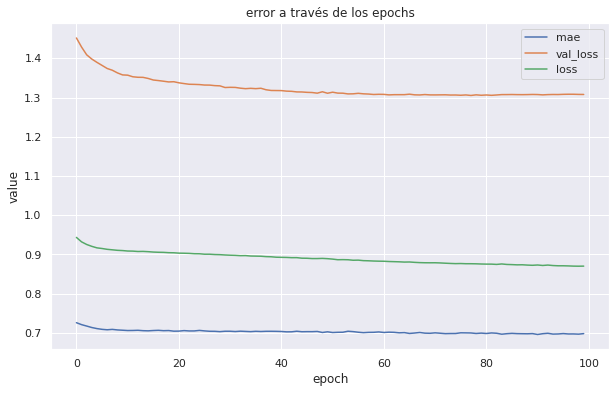

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.4913686519257163
MAE is : 0.8883668755448552
RMSE is : 1.2212160545643496
MAPE is : 42.95821704555887
Evaluation metric results:
MSE is : 1.2764263431831666
MAE is : 0.8570798937057041
RMSE is : 1.1297903978982857
MAPE is : 41.722568929403856
(632, 10, 1) (632, 1)
(266, 10, 1) (266, 1)
Epoch 1/100
32/32 [==============================] - 4s 29ms/step - loss: 0.9496 - mae: 0.7260 - val_loss: 1.4635 - val_mae: 0.7833
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9320 - mae: 0.7197 - val_loss: 1.4205 - val_mae: 0.7786
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9240 - mae: 0.7153 - val_loss: 1.3903 - val_mae: 0.7734
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9196 - mae: 0.7114 - val_loss: 1.3809 - val_mae: 0.7709
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9158 - mae: 0.7088 -

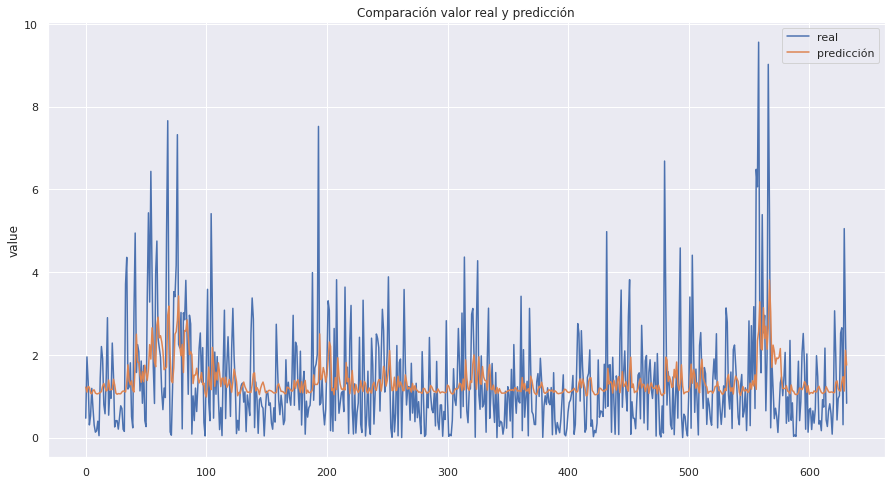

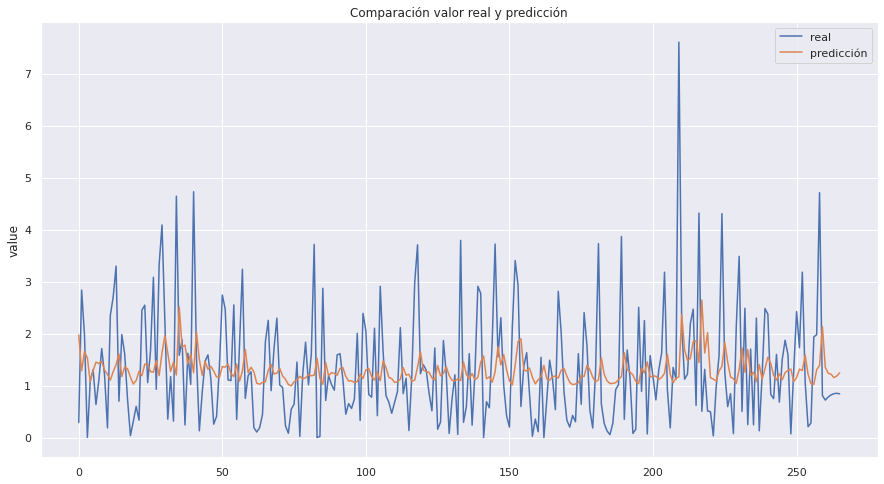

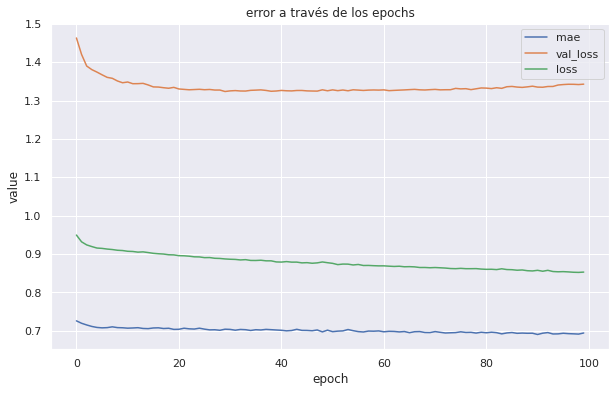

9/9 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.478557362532454
MAE is : 0.8833661483924402
RMSE is : 1.2159594411543726
MAPE is : 42.6994359679451
Evaluation metric results:
MSE is : 1.2765744363420202
MAE is : 0.8569851926629118
RMSE is : 1.1298559361007137
MAPE is : 41.589798197836274
(632, 10, 1) (632, 1)
(266, 10, 1) (266, 1)
Epoch 1/100
32/32 [==============================] - 3s 30ms/step - loss: 1.0070 - mae: 0.7475 - val_loss: 1.5305 - val_mae: 0.8028
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9533 - mae: 0.7291 - val_loss: 1.4457 - val_mae: 0.7987
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.9387 - mae: 0.7210 - val_loss: 1.4138 - val_mae: 0.7950
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9330 - mae: 0.7150 - val_loss: 1.4060 - val_mae: 0.7880
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.9258 - mae: 0.7107 - v

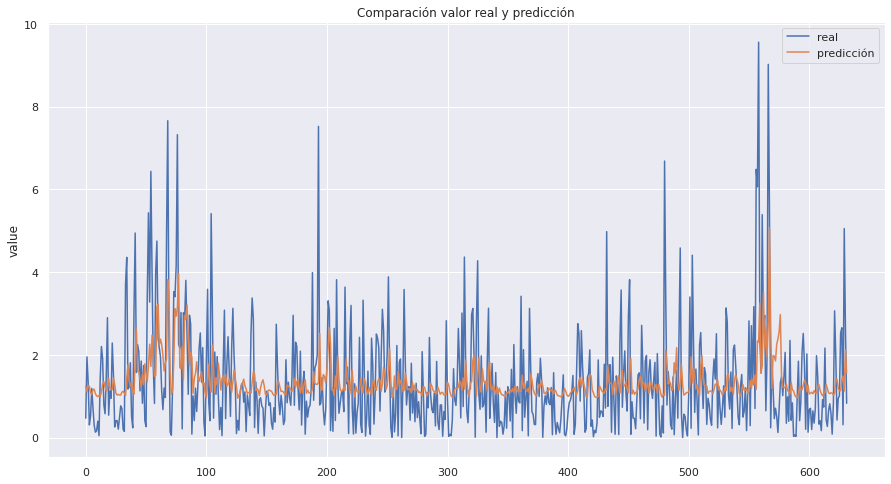

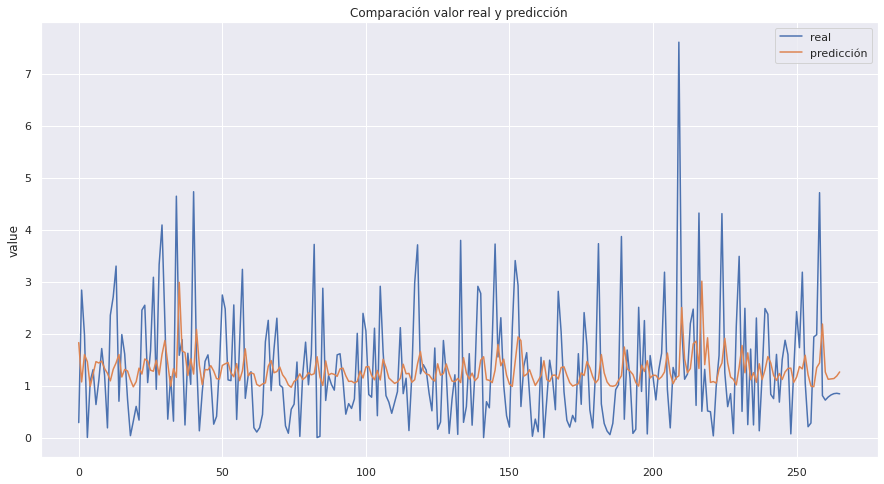

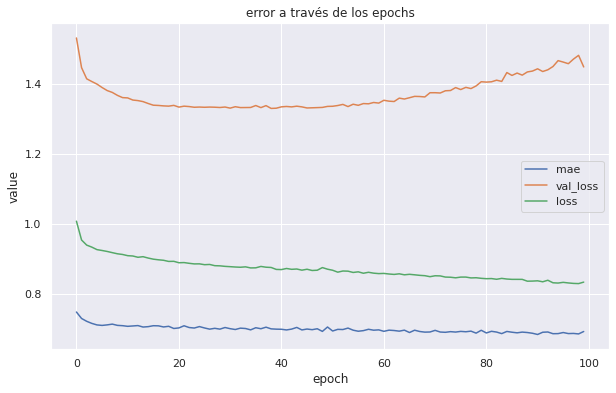

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.4853597392710276
MAE is : 0.8783958629750982
RMSE is : 1.2187533545681126
MAPE is : 42.00800797097689
Evaluation metric results:
MSE is : 1.2689157236939892
MAE is : 0.8543253581723105
RMSE is : 1.12646159441589
MAPE is : 40.82847684064635
(632, 10, 1) (632, 1)
(266, 10, 1) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 38ms/step - loss: 0.9316 - mae: 0.7137 - val_loss: 1.3714 - val_mae: 0.7766
Epoch 2/100
32/32 [==============================] - 0s 16ms/step - loss: 0.9204 - mae: 0.7146 - val_loss: 1.3621 - val_mae: 0.7811
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9161 - mae: 0.7124 - val_loss: 1.3505 - val_mae: 0.7831
Epoch 4/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9157 - mae: 0.7102 - val_loss: 1.3516 - val_mae: 0.7746
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9079 - mae: 0.7055 - va

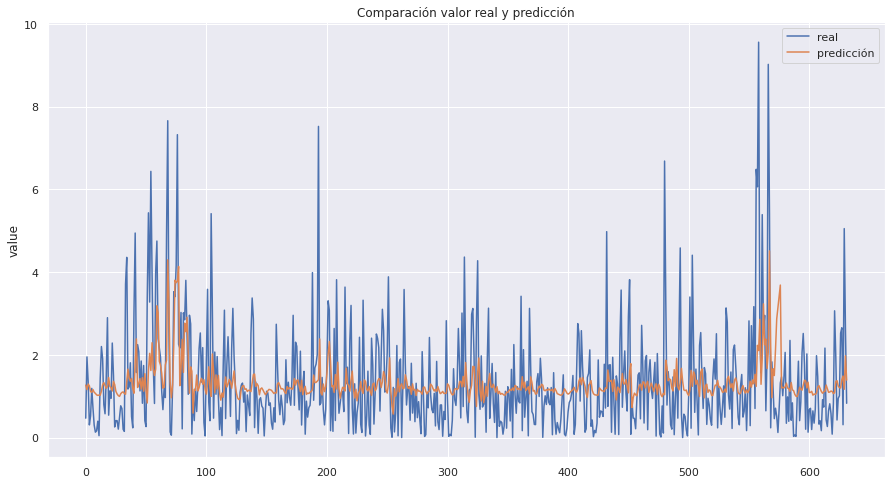

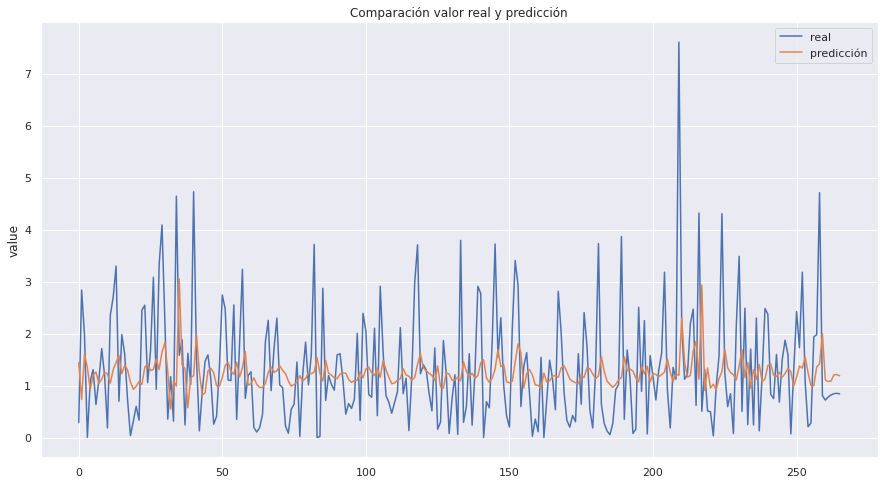

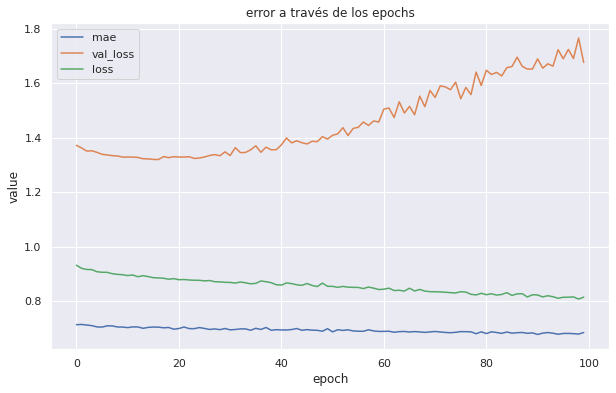

9/9 [==============================] - 0s 7ms/step
Evaluation metric results:
MSE is : 1.5391796352213465
MAE is : 0.884033014707205
RMSE is : 1.240636786179318
MAPE is : 42.57013266833734
Evaluation metric results:
MSE is : 1.2641528336702268
MAE is : 0.857063938207383
RMSE is : 1.1243455134744955
MAPE is : 41.33586614338359
(632, 10, 1) (632, 1)
(266, 10, 1) (266, 1)
Epoch 1/100
32/32 [==============================] - 5s 49ms/step - loss: 0.9335 - mae: 0.7105 - val_loss: 1.3679 - val_mae: 0.7800
Epoch 2/100
32/32 [==============================] - 1s 30ms/step - loss: 0.9218 - mae: 0.7172 - val_loss: 1.3579 - val_mae: 0.7831
Epoch 3/100
32/32 [==============================] - 1s 26ms/step - loss: 0.9146 - mae: 0.7128 - val_loss: 1.3468 - val_mae: 0.7845
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.9161 - mae: 0.7100 - val_loss: 1.3469 - val_mae: 0.7732
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 0.9045 - mae: 0.7043 - val

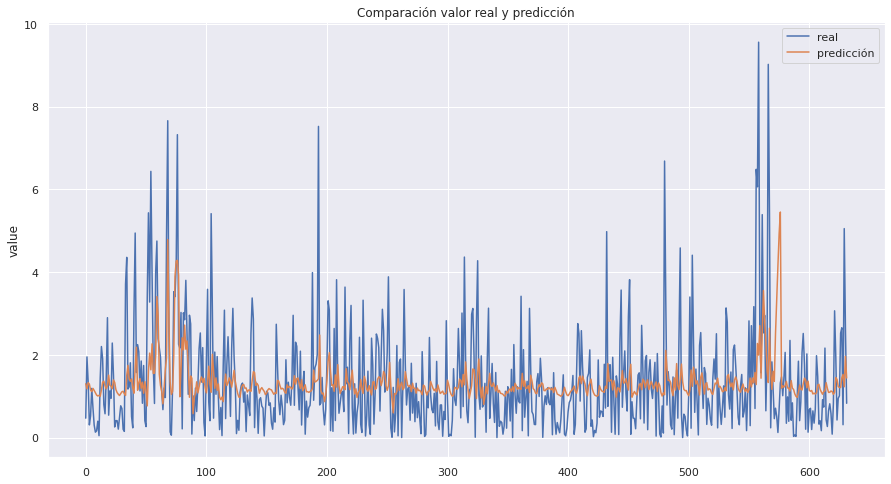

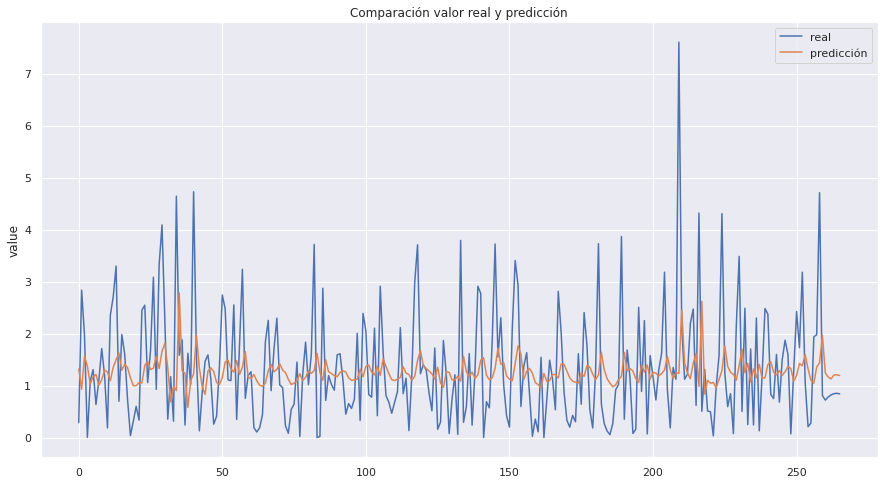

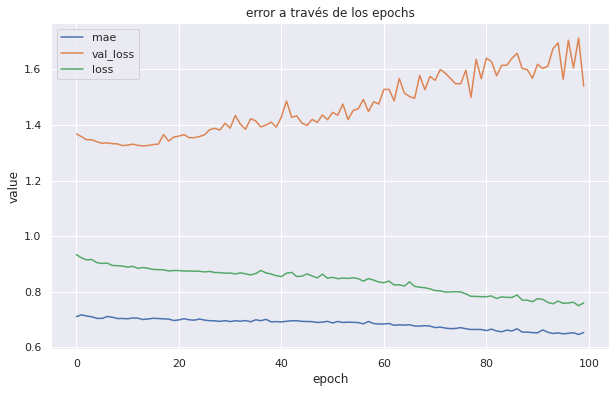

9/9 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 1.4139679327627737
MAE is : 0.8457128556917022
RMSE is : 1.1891038359885875
MAPE is : 41.19157468911593
Evaluation metric results:
MSE is : 1.3871418978127366
MAE is : 0.8925527172202585
RMSE is : 1.1777698832168941
MAPE is : 43.63125504476971
(632, 10, 1) (632, 1)
(266, 10, 1) (266, 1)
Epoch 1/100
32/32 [==============================] - 7s 89ms/step - loss: 0.9379 - mae: 0.7094 - val_loss: 1.3733 - val_mae: 0.7719
Epoch 2/100
32/32 [==============================] - 2s 67ms/step - loss: 0.9221 - mae: 0.7189 - val_loss: 1.3425 - val_mae: 0.7914
Epoch 3/100
32/32 [==============================] - 2s 66ms/step - loss: 0.9095 - mae: 0.7099 - val_loss: 1.3424 - val_mae: 0.7748
Epoch 4/100
32/32 [==============================] - 2s 63ms/step - loss: 0.9158 - mae: 0.7101 - val_loss: 1.3376 - val_mae: 0.7680
Epoch 5/100
32/32 [==============================] - 2s 66ms/step - loss: 0.8998 - mae: 0.7023 -

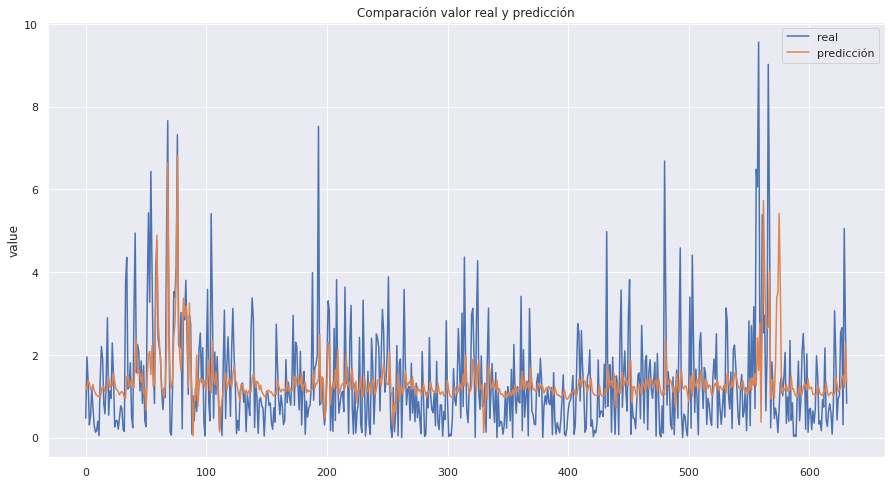

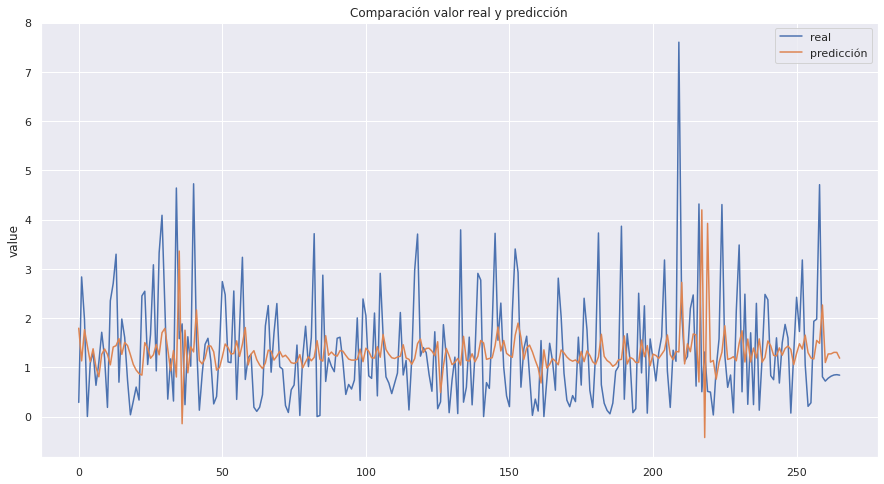

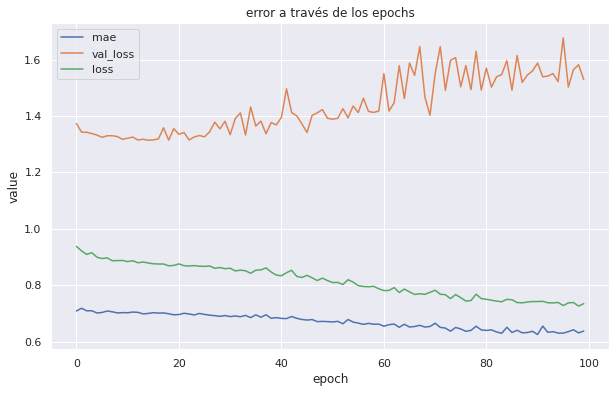

9/9 [==============================] - 0s 14ms/step
Evaluation metric results:
MSE is : 1.3841866461145371
MAE is : 0.8142041230654751
RMSE is : 1.1765146178924157
MAPE is : 38.92945472767608
Evaluation metric results:
MSE is : 1.4055462403176453
MAE is : 0.8932855357789572
RMSE is : 1.1855573542927584
MAPE is : 42.9141514932073
(627, 15, 1) (627, 1)
(261, 15, 1) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 37ms/step - loss: 0.9560 - mae: 0.7379 - val_loss: 1.4976 - val_mae: 0.7925
Epoch 2/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9404 - mae: 0.7205 - val_loss: 1.4775 - val_mae: 0.7803
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9320 - mae: 0.7159 - val_loss: 1.4614 - val_mae: 0.7796
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9273 - mae: 0.7127 - val_loss: 1.4490 - val_mae: 0.7760
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9245 - mae: 0.7089 - 

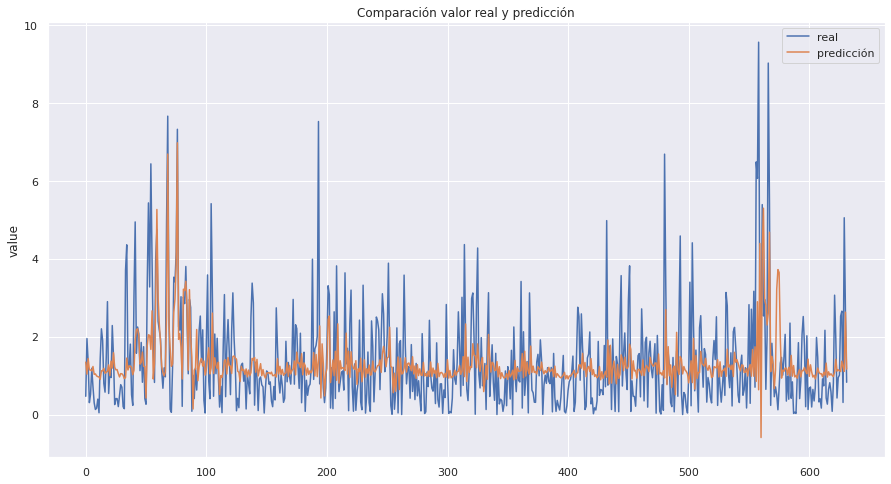

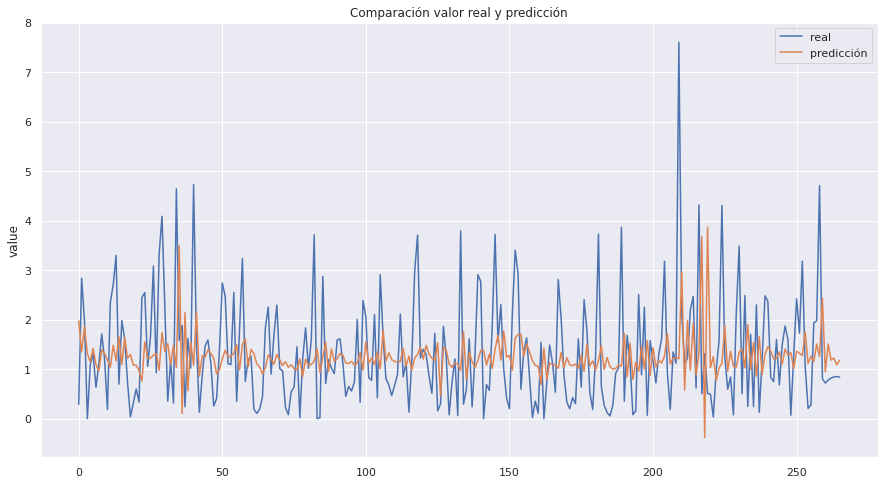

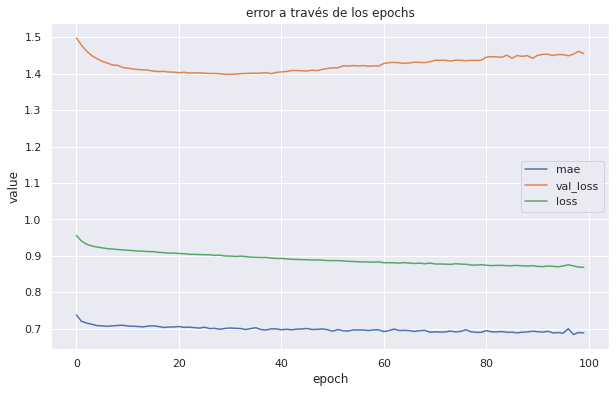

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.5347510013037744
MAE is : 0.8917225547477078
RMSE is : 1.2388506775652077
MAPE is : 43.10231677500842
Evaluation metric results:
MSE is : 1.2409846799409716
MAE is : 0.8518387682742213
RMSE is : 1.1139949191719734
MAPE is : 41.16530943265765
(627, 15, 1) (627, 1)
(261, 15, 1) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 42ms/step - loss: 0.9382 - mae: 0.7247 - val_loss: 1.4353 - val_mae: 0.7789
Epoch 2/100
32/32 [==============================] - 0s 16ms/step - loss: 0.9250 - mae: 0.7119 - val_loss: 1.4131 - val_mae: 0.7709
Epoch 3/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9200 - mae: 0.7125 - val_loss: 1.3984 - val_mae: 0.7751
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.9172 - mae: 0.7115 - val_loss: 1.3909 - val_mae: 0.7741
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.9156 - mae: 0.7086 - 

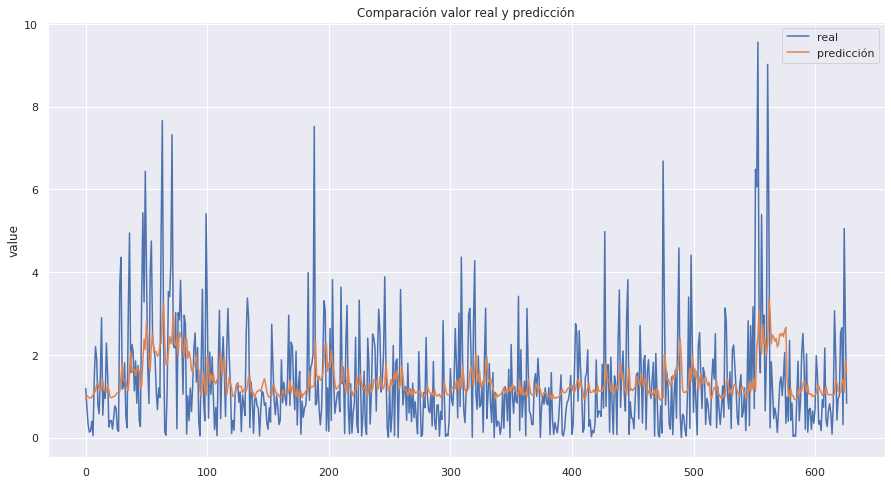

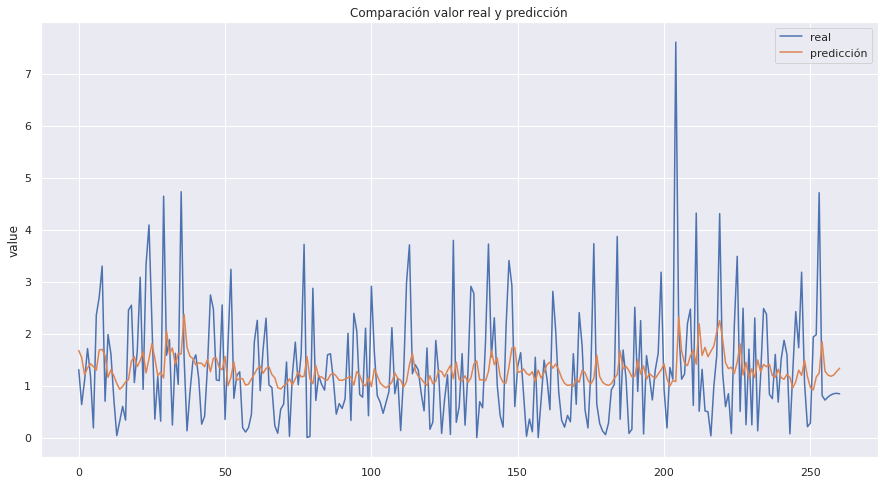

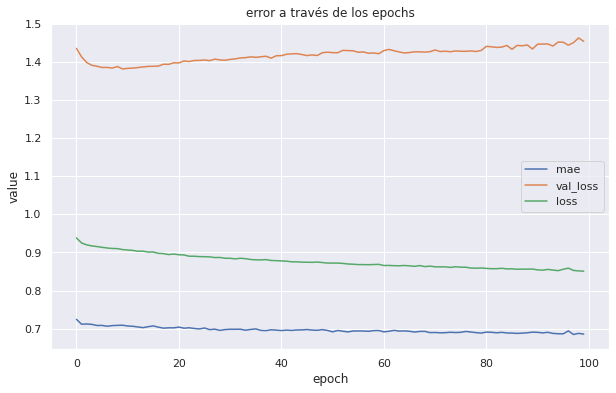

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.5111077627572336
MAE is : 0.8872469360694094
RMSE is : 1.2292712323800772
MAPE is : 42.809897626267656
Evaluation metric results:
MSE is : 1.2420627522560332
MAE is : 0.8518050785875083
RMSE is : 1.1144786908039261
MAPE is : 41.075069085964365
(627, 15, 1) (627, 1)
(261, 15, 1) (261, 1)
Epoch 1/100
32/32 [==============================] - 4s 40ms/step - loss: 0.9476 - mae: 0.7318 - val_loss: 1.4570 - val_mae: 0.7952
Epoch 2/100
32/32 [==============================] - 1s 16ms/step - loss: 0.9302 - mae: 0.7104 - val_loss: 1.4482 - val_mae: 0.7881
Epoch 3/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9245 - mae: 0.7138 - val_loss: 1.4378 - val_mae: 0.7942
Epoch 4/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9207 - mae: 0.7123 - val_loss: 1.4328 - val_mae: 0.7913
Epoch 5/100
32/32 [==============================] - 1s 17ms/step - loss: 0.9171 - mae: 0.7075 

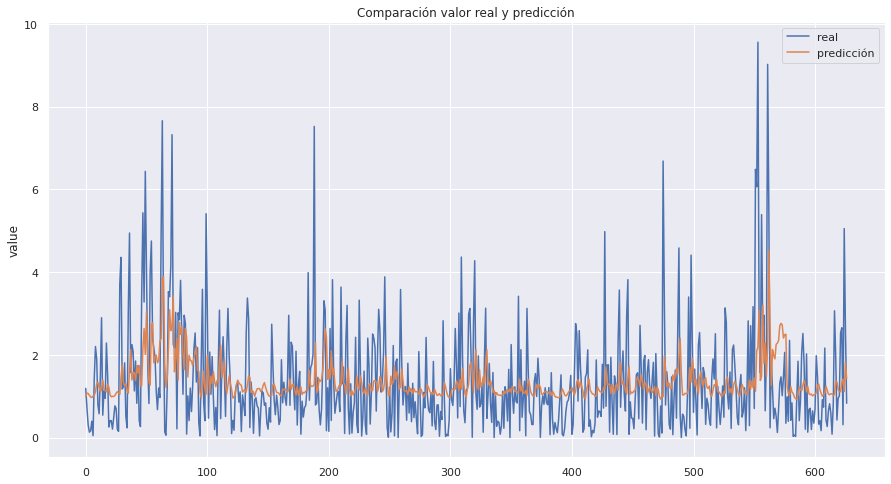

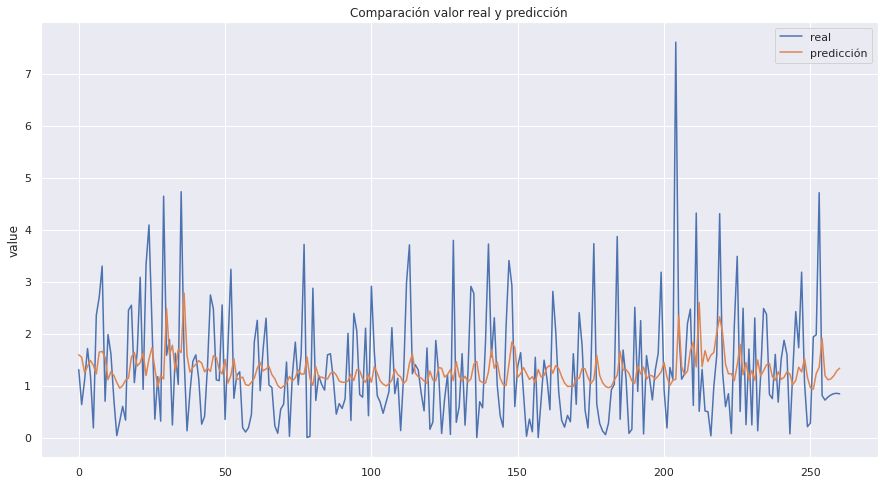

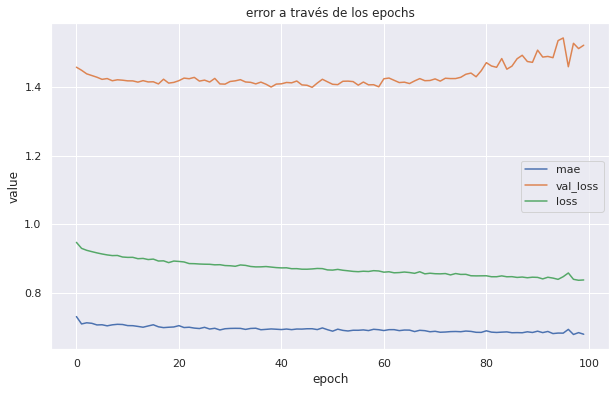

9/9 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.5118554517163838
MAE is : 0.8906445581101556
RMSE is : 1.229575313560086
MAPE is : 43.20281764680555
Evaluation metric results:
MSE is : 1.247876284690567
MAE is : 0.8536967769304115
RMSE is : 1.117083830645922
MAPE is : 41.20791600130199
(627, 15, 1) (627, 1)
(261, 15, 1) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 44ms/step - loss: 0.9343 - mae: 0.7229 - val_loss: 1.4238 - val_mae: 0.7862
Epoch 2/100
32/32 [==============================] - 1s 21ms/step - loss: 0.9225 - mae: 0.7058 - val_loss: 1.4282 - val_mae: 0.7812
Epoch 3/100
32/32 [==============================] - 1s 21ms/step - loss: 0.9176 - mae: 0.7133 - val_loss: 1.4283 - val_mae: 0.7922
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9135 - mae: 0.7098 - val_loss: 1.4299 - val_mae: 0.7894
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 0.9090 - mae: 0.7041 - val

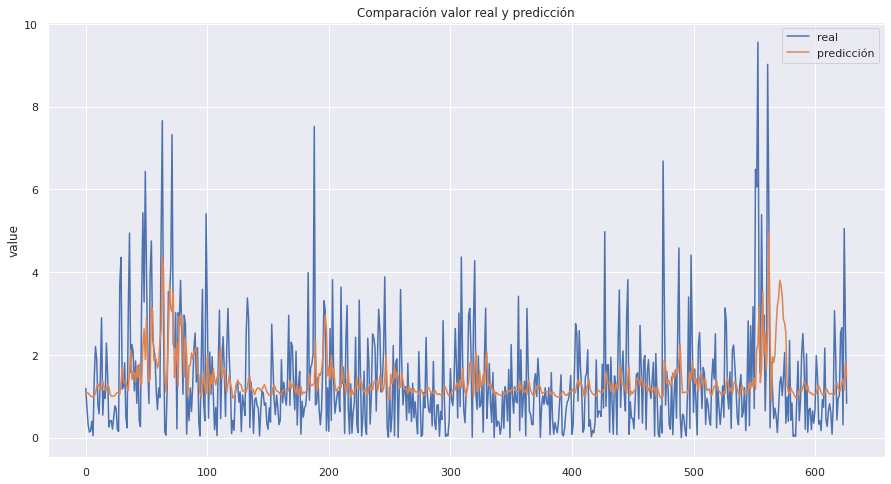

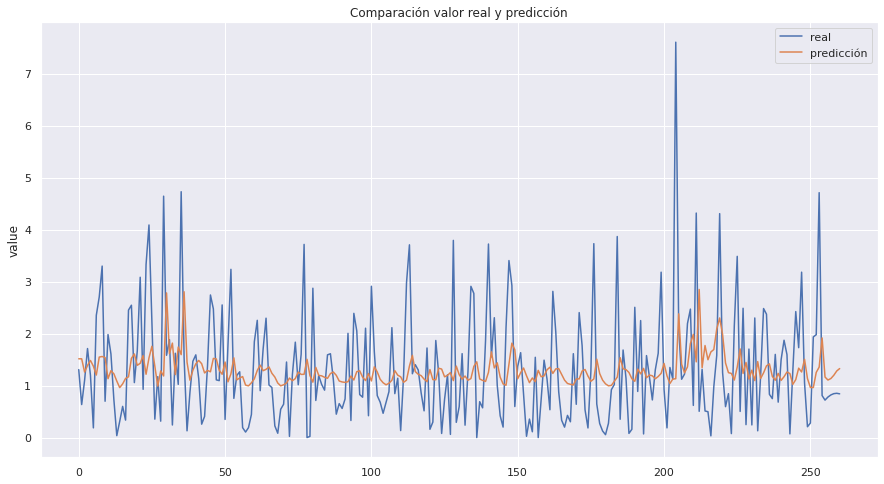

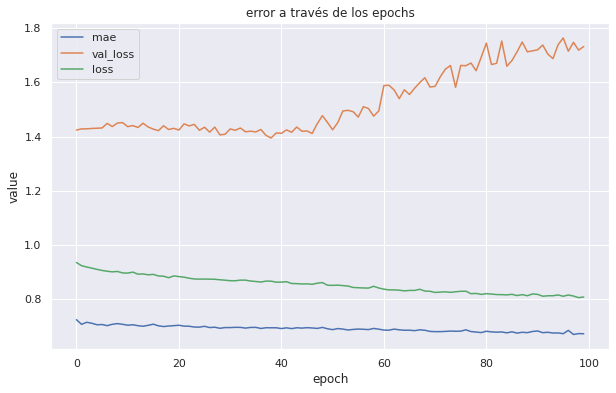

9/9 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 1.5361926446544463
MAE is : 0.876706043656973
RMSE is : 1.2394323880932134
MAPE is : 42.790513890531464
Evaluation metric results:
MSE is : 1.237289980398162
MAE is : 0.8425138753023584
RMSE is : 1.1123353722678075
MAPE is : 40.43608456782639
(627, 15, 1) (627, 1)
(261, 15, 1) (261, 1)
Epoch 1/100
32/32 [==============================] - 5s 57ms/step - loss: 0.9360 - mae: 0.7220 - val_loss: 1.4190 - val_mae: 0.7800
Epoch 2/100
32/32 [==============================] - 1s 35ms/step - loss: 0.9217 - mae: 0.7037 - val_loss: 1.4260 - val_mae: 0.7791
Epoch 3/100
32/32 [==============================] - 1s 35ms/step - loss: 0.9174 - mae: 0.7158 - val_loss: 1.4288 - val_mae: 0.7911
Epoch 4/100
32/32 [==============================] - 1s 36ms/step - loss: 0.9096 - mae: 0.7094 - val_loss: 1.4225 - val_mae: 0.7839
Epoch 5/100
32/32 [==============================] - 1s 34ms/step - loss: 0.9048 - mae: 0.7023 - v

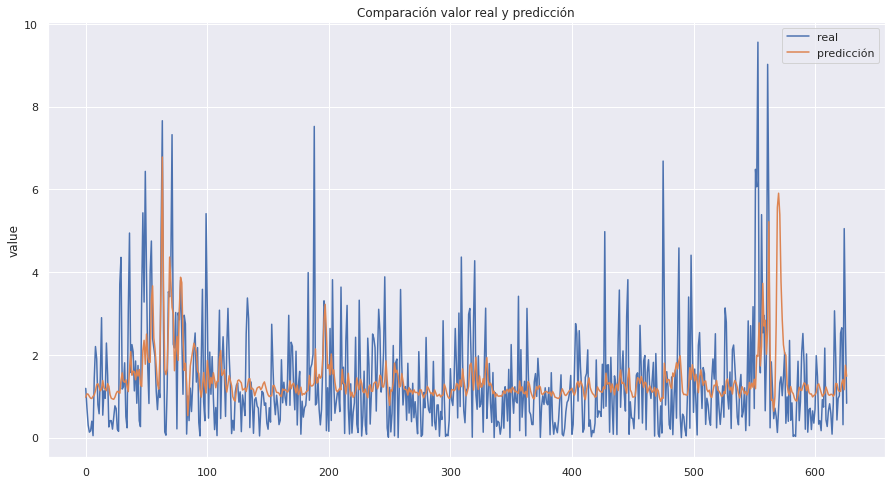

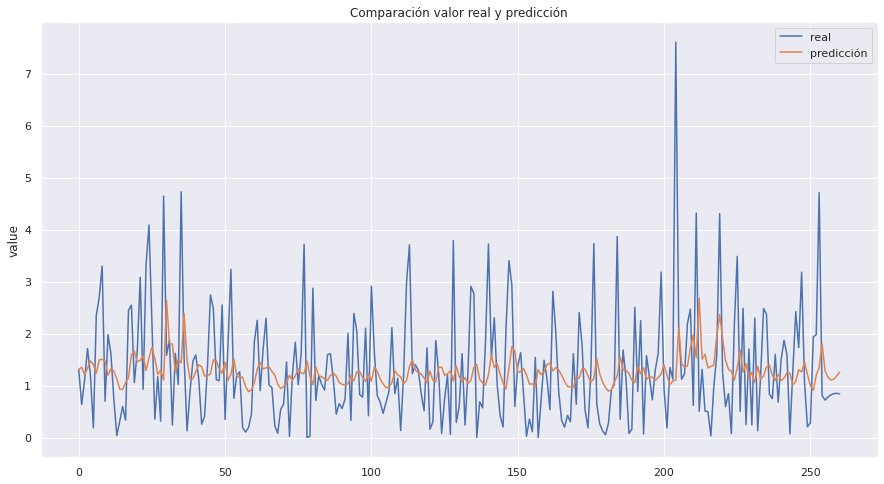

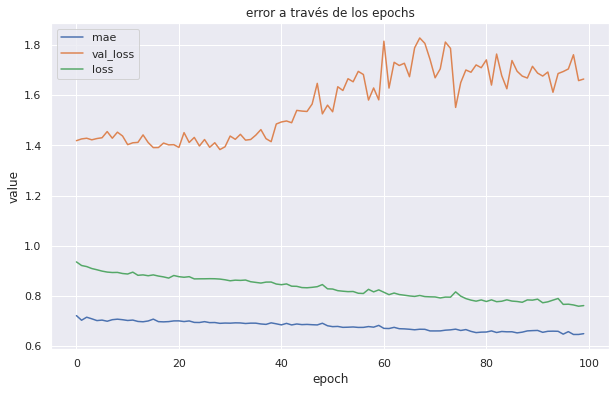

9/9 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 1.4514860673419838
MAE is : 0.8447364420220514
RMSE is : 1.204776355736609
MAPE is : 41.29247711512279
Evaluation metric results:
MSE is : 1.2637661311210737
MAE is : 0.8473270317509547
RMSE is : 1.1241735324766695
MAPE is : 40.90272195612345
(627, 15, 1) (627, 1)
(261, 15, 1) (261, 1)
Epoch 1/100
32/32 [==============================] - 7s 95ms/step - loss: 0.9357 - mae: 0.7212 - val_loss: 1.4102 - val_mae: 0.7717
Epoch 2/100
32/32 [==============================] - 2s 70ms/step - loss: 0.9163 - mae: 0.7021 - val_loss: 1.4194 - val_mae: 0.7800
Epoch 3/100
32/32 [==============================] - 2s 67ms/step - loss: 0.9132 - mae: 0.7173 - val_loss: 1.4088 - val_mae: 0.7779
Epoch 4/100
32/32 [==============================] - 2s 68ms/step - loss: 0.9013 - mae: 0.7077 - val_loss: 1.3876 - val_mae: 0.7737
Epoch 5/100
32/32 [==============================] - 2s 68ms/step - loss: 0.8971 - mae: 0.7012 - 

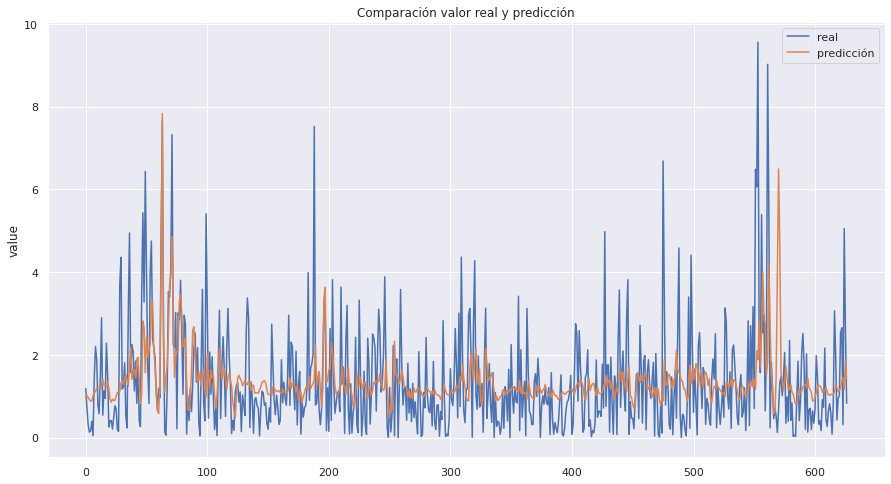

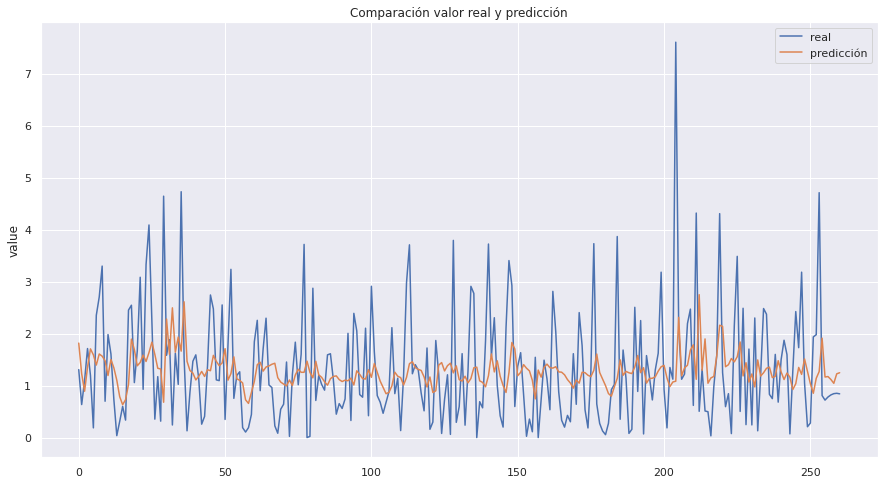

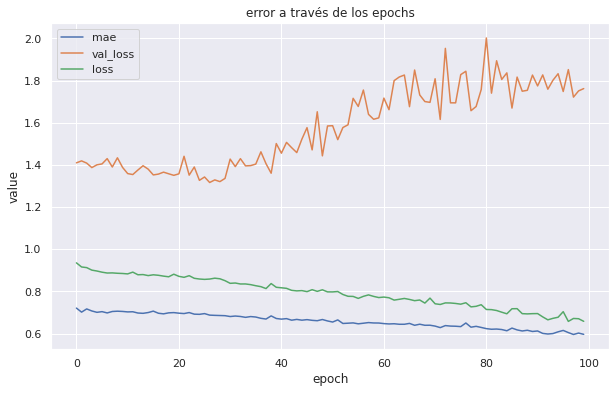

9/9 [==============================] - 0s 23ms/step
Evaluation metric results:
MSE is : 1.3346133914117024
MAE is : 0.7832562528407931
RMSE is : 1.1552546868165923
MAPE is : 38.38318248367341
Evaluation metric results:
MSE is : 1.4373749726975351
MAE is : 0.8897858152611479
RMSE is : 1.1989057397049758
MAPE is : 42.43148274153394


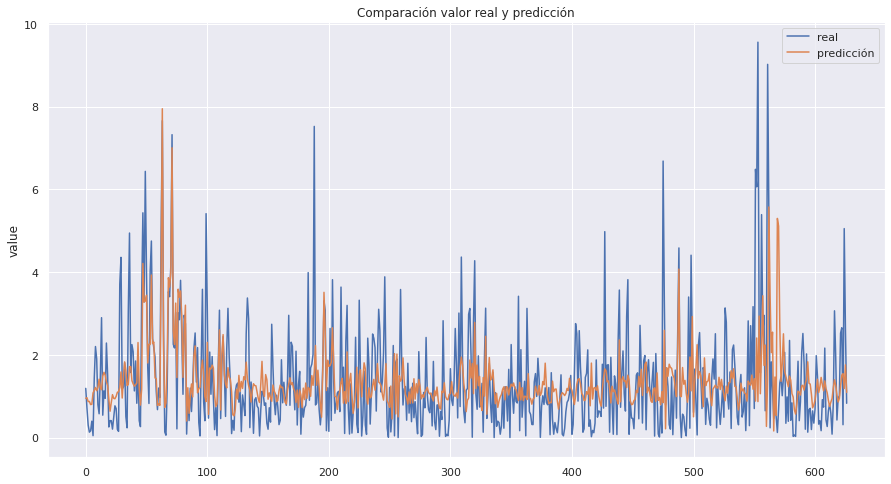

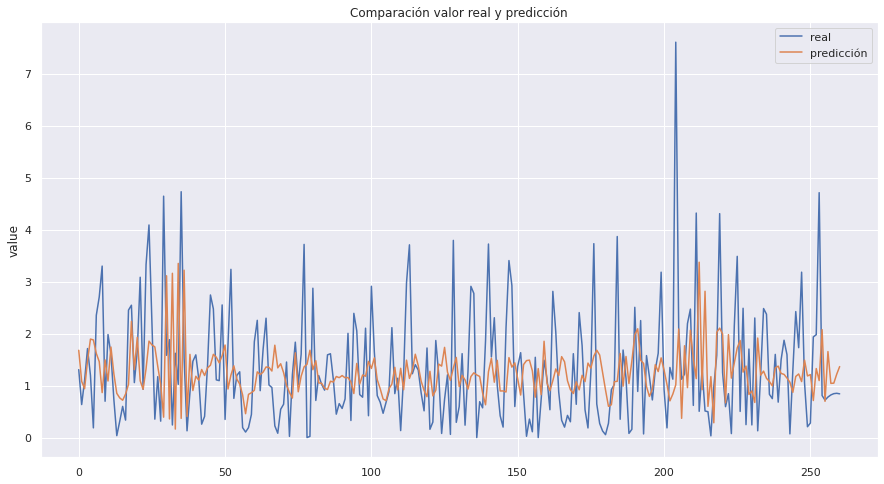

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=1,epochss=100,batch_sizze=16,lag=lg)